In [12]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd
from classes_synsets import SYNS

In [13]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [14]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [15]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [16]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [17]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
text_embs.shape

torch.Size([1000, 1024])

In [19]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [20]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [21]:
many_labels = []
many_embs = []
many_inds = []
med_labels = []
med_embs = []
med_inds = []
few_labels = []
few_embs = []
few_inds = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
        many_inds.append(i)
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
        med_inds.append(i)
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        few_inds.append(i)
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

many_inds = np.array(many_inds)
med_inds = np.array(med_inds)
few_inds = np.array(few_inds)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [22]:
many_labels_val = []
many_embs_val = []
many_inds_val = []
med_labels_val = []
med_embs_val = []
med_inds_val = []
few_labels_val = []
few_embs_val = []
few_inds_val = []

for i in tqdm(range(image_embeddings_val.shape[0])):
    if freqs[labels_val[i].item()] >= 100:
        many_labels_val.append(labels_val[i])
        many_embs_val.append(image_embeddings_val[i, :])
        many_inds_val.append(i)
    elif freqs[labels_val[i].item()] >= 20:
        med_labels_val.append(labels_val[i])
        med_embs_val.append(image_embeddings_val[i, :])
        med_inds_val.append(i)
    else:
        few_labels_val.append(labels_val[i])
        few_embs_val.append(image_embeddings_val[i, :])
        few_inds_val.append(i)
        
many_embs_val = torch.stack(many_embs_val)
med_embs_val = torch.stack(med_embs_val)
few_embs_val = torch.stack(few_embs_val)

many_inds_val = np.array(many_inds_val)
med_inds_val = np.array(med_inds_val)
few_inds_val = np.array(few_inds_val)

  0%|          | 0/20000 [00:00<?, ?it/s]

### Image only Eval

In [11]:
predictions_all = clf.predict(image_embeddings)
avg_acc = mic_acc_cal(predictions_all, labels.numpy())
avg_acc

0.62202

In [12]:
predictions = clf.predict(small_ie)
avg_acc = mic_acc_cal(predictions, small_labels.numpy())
avg_acc

0.6196

### Alternate Train(?) Scheme: Leveraging CLIP Zero-shot top-K 

In [13]:
import sklearn 
pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), text_embs.cpu())

KeyboardInterrupt: 

In [13]:
def top_k_acc(pairwise_cs, k, labels):
    indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(a`xis=-1)[:, :k]
    acc = 0
    for i in range(indices.shape[0]):
        if labels[i].item() in indices[i]:
            acc +=1.0
    acc/= indices.shape[0]
    return acc

SyntaxError: invalid syntax (4010072867.py, line 2)

In [44]:
for i in range(1, 20):
    acc = top_k_acc(pairwise_cs, i, labels)
    print(f"Top {i} zero-shot accuracy: {acc}")

Top 1 zero-shot accuracy: 0.5818
Top 2 zero-shot accuracy: 0.7236
Top 3 zero-shot accuracy: 0.78856
Top 4 zero-shot accuracy: 0.82564
Top 5 zero-shot accuracy: 0.8524
Top 6 zero-shot accuracy: 0.87132
Top 7 zero-shot accuracy: 0.88542
Top 8 zero-shot accuracy: 0.89648
Top 9 zero-shot accuracy: 0.9047
Top 10 zero-shot accuracy: 0.91268
Top 11 zero-shot accuracy: 0.91892
Top 12 zero-shot accuracy: 0.92478
Top 13 zero-shot accuracy: 0.92928
Top 14 zero-shot accuracy: 0.93374
Top 15 zero-shot accuracy: 0.93726
Top 16 zero-shot accuracy: 0.9405
Top 17 zero-shot accuracy: 0.9432
Top 18 zero-shot accuracy: 0.94606
Top 19 zero-shot accuracy: 0.94848


### Alternate Train(?) scheme: Only FT on Image and only FT on Text

In [23]:
def all_accs(model):
    preds = model.predict(image_embeddings)
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [24]:
def all_accs_p(preds):
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [25]:
def all_accs_p_val(preds):
    l = labels_val.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds_val], many_labels_val)
    med = mic_acc_cal(preds[med_inds_val], med_labels_val)
    few = mic_acc_cal(preds[few_inds_val], few_labels_val)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [26]:
conv_comb_0_8_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

# text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_0/29-Sep-2022-01-32-28/final_model.sav", 'rb'))
text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))
# text_only_balanced_clf_3 = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))


image_only_clf = pickle.load(open("results_sklearn/config_image_linear_probe_0/class_balanced/13-Sep-2022-01-35-07/final_model.sav", 'rb'))
image_only_clf_2 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/29-Sep-2022-01-38-27/final_model.sav", 'rb'))
image_only_clf_3 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/07-Nov-2022-18-27-46/final_model.sav", 'rb'))
image_only_clf_4 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_oversampled_auto/class_balanced/07-Nov-2022-20-13-26/final_model.sav", 'rb'))
# image_only_clf_oversampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_undersampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_0-5/12-Nov-2022-12-17-52/final_model.sav", 'rb'))
image_only_clf_undersampled = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_auto/class_balanced/07-Nov-2022-20-18-24/final_model.sav", 'rb'))
oversampled_conv_comb_clf = pickle.load(open("results_sklearn/config_convex_comb_oversampled_auto/02-Dec-2022-05-42-24/final_model.sav", 'rb'))


In [191]:
all_accs(conv_comb_0_8_clf)

0.622/0.710/0.613/0.400


[0.62202, 0.7104347826086956, 0.6126849894291755, 0.4002941176470588]

In [38]:
all_accs(text_only_balanced_clf)

0.544/0.558/0.542/0.512


In [39]:
all_accs(image_only_clf)
all_accs(image_only_clf_2)
all_accs(image_only_clf_3)
all_accs(image_only_clf_4)

0.595/0.653/0.585/0.461
0.608/0.735/0.579/0.345
0.608/0.735/0.579/0.345
0.609/0.735/0.581/0.345


In [40]:
all_accs(image_only_clf_oversampled)

0.621/0.721/0.606/0.386


In [41]:
all_accs(image_only_clf_undersampled_500)
all_accs(image_only_clf_undersampled)

0.376/0.717/0.202/0.001
0.315/0.326/0.308/0.304


In [42]:
# Zero Shot CLIP
acc = top_k_acc(pairwise_cs, 1, labels)
print(acc)

0.58142


### Mixing Logits

In [18]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []

def inv_softmax(x, C):
    return np.log(x) + C

for i in reversed(range(0, 21)):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    one = inv_softmax(text_only_balanced_clf.predict_proba(image_embeddings),np.log(10,))
    two = inv_softmax(image_only_clf_oversampled.predict_proba(image_embeddings),np.log(10,))
    fin = i*(one) + (i-1)*two
    preds = np.argmax(fin, axis=-1)
    test_acc = all_accs_p(preds)
    test_accs_range.append(test_acc[0])
    many_accs_range.append(test_acc[1])
    med_accs_range.append(test_acc[2])
    few_accs_range.append(test_acc[3])

Mixing coeff: 1.00
0.544/0.558/0.542/0.512
Mixing coeff: 0.95
0.461/0.460/0.460/0.463
Mixing coeff: 0.90
0.279/0.260/0.277/0.342
Mixing coeff: 0.85
0.046/0.034/0.039/0.106
Mixing coeff: 0.80
0.003/0.001/0.001/0.013
Mixing coeff: 0.75


KeyboardInterrupt: 

KeyboardInterrupt: 

### Mixing

In [43]:
# Mixing over and under sampled
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
for i in range(0, 21):
    i = i/20.0
    mixed_clf.coef_ = i*image_only_clf_undersampled.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*image_only_clf_undersampled.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    val_acc = mic_acc_cal(mixed_clf.predict(image_embeddings_val), labels_val.numpy())
    test_acc = mic_acc_cal(mixed_clf.predict(image_embeddings), labels.numpy())
    val_accs_range.append(val_acc)
    test_accs_range.append(test_acc)
    print(f"Mixing coeff: {i}, Acc Val: {val_acc}, Acc Test: {test_acc}")

Mixing coeff: 0.0, Acc Val: 0.63425, Acc Test: 0.62108
Mixing coeff: 0.05, Acc Val: 0.6342, Acc Test: 0.62106
Mixing coeff: 0.1, Acc Val: 0.63465, Acc Test: 0.62124
Mixing coeff: 0.15, Acc Val: 0.63485, Acc Test: 0.62134
Mixing coeff: 0.2, Acc Val: 0.6349, Acc Test: 0.62128
Mixing coeff: 0.25, Acc Val: 0.6347, Acc Test: 0.6207
Mixing coeff: 0.3, Acc Val: 0.6341, Acc Test: 0.62054
Mixing coeff: 0.35, Acc Val: 0.63395, Acc Test: 0.62038
Mixing coeff: 0.4, Acc Val: 0.6331, Acc Test: 0.62012
Mixing coeff: 0.45, Acc Val: 0.633, Acc Test: 0.61984
Mixing coeff: 0.5, Acc Val: 0.6319, Acc Test: 0.6188
Mixing coeff: 0.55, Acc Val: 0.63035, Acc Test: 0.61754
Mixing coeff: 0.6, Acc Val: 0.62905, Acc Test: 0.61656
Mixing coeff: 0.65, Acc Val: 0.6263, Acc Test: 0.61414
Mixing coeff: 0.7, Acc Val: 0.6214, Acc Test: 0.61012
Mixing coeff: 0.75, Acc Val: 0.61495, Acc Test: 0.60238
Mixing coeff: 0.8, Acc Val: 0.6049, Acc Test: 0.59138
Mixing coeff: 0.85, Acc Val: 0.5869, Acc Test: 0.57164
Mixing coeff: 0

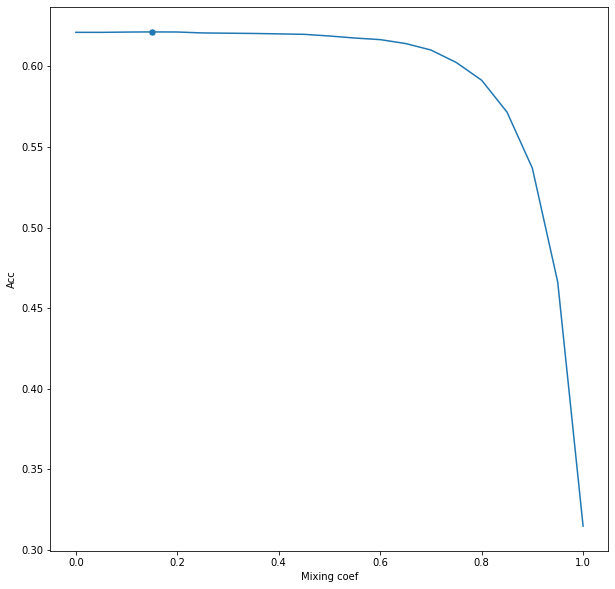

In [57]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
x = [i/20.0 for i in range(0, 21)]
m = np.argmax(test_accs_range)
sns.scatterplot(x = [x[m]], y = [test_accs_range[m]], marker='o', s=50)
ax = sns.lineplot(x = x, y = test_accs_range)
ax.set(xlabel='Mixing coef', ylabel='Acc')
plt.show()

In [101]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
for i in range(0, 21):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf.intercept_
    val_acc = mic_acc_cal(mixed_clf.predict(image_embeddings_val), labels_val.numpy())
    test_acc = mic_acc_cal(mixed_clf.predict(image_embeddings), labels.numpy())
    val_accs_range.append(val_acc)
    test_accs_range.append(test_acc)
    print(f"Mixing coeff: {i}, Acc Val: {val_acc}, Acc Test: {test_acc}")

Mixing coeff: 0.0, Acc Val: 0.6208, Acc Test: 0.6084
Mixing coeff: 0.05, Acc Val: 0.62275, Acc Test: 0.61036
Mixing coeff: 0.1, Acc Val: 0.6237, Acc Test: 0.6125
Mixing coeff: 0.15, Acc Val: 0.6259, Acc Test: 0.61464
Mixing coeff: 0.2, Acc Val: 0.6282, Acc Test: 0.61724
Mixing coeff: 0.25, Acc Val: 0.6301, Acc Test: 0.6194
Mixing coeff: 0.3, Acc Val: 0.6328, Acc Test: 0.62136
Mixing coeff: 0.35, Acc Val: 0.63515, Acc Test: 0.62344
Mixing coeff: 0.4, Acc Val: 0.6386, Acc Test: 0.62578
Mixing coeff: 0.45, Acc Val: 0.64075, Acc Test: 0.62874
Mixing coeff: 0.5, Acc Val: 0.6425, Acc Test: 0.6313
Mixing coeff: 0.55, Acc Val: 0.6445, Acc Test: 0.633
Mixing coeff: 0.6, Acc Val: 0.64585, Acc Test: 0.63456
Mixing coeff: 0.65, Acc Val: 0.6476, Acc Test: 0.63598
Mixing coeff: 0.7, Acc Val: 0.6476, Acc Test: 0.63618
Mixing coeff: 0.75, Acc Val: 0.6465, Acc Test: 0.63668
Mixing coeff: 0.8, Acc Val: 0.6416, Acc Test: 0.63222
Mixing coeff: 0.85, Acc Val: 0.63395, Acc Test: 0.62384
Mixing coeff: 0.9, A

In [108]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
for i in range(0, 21):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf_2.intercept_ + (1-i)*image_only_clf.intercept_
    val_acc = mic_acc_cal(mixed_clf.predict(image_embeddings_val), labels_val.numpy())
    test_acc = mic_acc_cal(mixed_clf.predict(image_embeddings), labels.numpy())
    val_accs_range.append(val_acc)
    test_accs_range.append(test_acc)
    print(f"Mixing coeff: {i}, Acc Val: {val_acc}, Acc Test: {test_acc}")

Mixing coeff: 0.0, Acc Val: 0.6208, Acc Test: 0.6084
Mixing coeff: 0.05, Acc Val: 0.6228, Acc Test: 0.61034
Mixing coeff: 0.1, Acc Val: 0.6242, Acc Test: 0.6127
Mixing coeff: 0.15, Acc Val: 0.62635, Acc Test: 0.61492
Mixing coeff: 0.2, Acc Val: 0.62885, Acc Test: 0.61732
Mixing coeff: 0.25, Acc Val: 0.63155, Acc Test: 0.6193
Mixing coeff: 0.3, Acc Val: 0.6336, Acc Test: 0.62162
Mixing coeff: 0.35, Acc Val: 0.6362, Acc Test: 0.62376
Mixing coeff: 0.4, Acc Val: 0.63985, Acc Test: 0.62636
Mixing coeff: 0.45, Acc Val: 0.6437, Acc Test: 0.62932
Mixing coeff: 0.5, Acc Val: 0.64525, Acc Test: 0.63214
Mixing coeff: 0.55, Acc Val: 0.64685, Acc Test: 0.63474
Mixing coeff: 0.6, Acc Val: 0.65015, Acc Test: 0.63654
Mixing coeff: 0.65, Acc Val: 0.6529, Acc Test: 0.6387
Mixing coeff: 0.7, Acc Val: 0.6536, Acc Test: 0.64004
Mixing coeff: 0.75, Acc Val: 0.65455, Acc Test: 0.6394
Mixing coeff: 0.8, Acc Val: 0.65105, Acc Test: 0.63952
Mixing coeff: 0.85, Acc Val: 0.64465, Acc Test: 0.6336
Mixing coeff: 0

In [109]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []
for i in range(0, 21):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf_2.intercept_ + (1-i)*image_only_clf.intercept_
    many_accs_range.append(mic_acc_cal(mixed_clf.predict(many_embs), many_labels))
    med_accs_range.append(mic_acc_cal(mixed_clf.predict(med_embs), med_labels))
    few_accs_range.append(mic_acc_cal(mixed_clf.predict(few_embs), few_labels))
    print(f"Mixing coeff: {i}, Many: {many_accs_range[-1]}, Med: {med_accs_range[-1]}, Few: {few_accs_range[-1]}")

Mixing coeff: 0.0, Many: 0.7351918158567775, Med: 0.5793657505285412, Few: 0.3448529411764706
Mixing coeff: 0.05, Many: 0.7362148337595908, Med: 0.5816490486257928, Few: 0.34823529411764703
Mixing coeff: 0.1, Many: 0.7376470588235294, Med: 0.5841437632135307, Few: 0.3527941176470588
Mixing coeff: 0.15, Many: 0.7385166240409207, Med: 0.5868498942917547, Few: 0.35720588235294115
Mixing coeff: 0.2, Many: 0.7393350383631714, Med: 0.5901057082452431, Few: 0.3611764705882353
Mixing coeff: 0.25, Many: 0.739693094629156, Med: 0.5926427061310783, Few: 0.3658823529411765
Mixing coeff: 0.3, Many: 0.7405115089514066, Med: 0.5954334038054968, Few: 0.3708823529411765
Mixing coeff: 0.35, Many: 0.741381074168798, Med: 0.597970401691332, Few: 0.37529411764705883
Mixing coeff: 0.4, Many: 0.7423017902813299, Med: 0.6010570824524313, Few: 0.3810294117647059
Mixing coeff: 0.45, Many: 0.7427109974424553, Med: 0.6049048625792812, Few: 0.38823529411764707
Mixing coeff: 0.5, Many: 0.7423529411764705, Med: 0.60

In [65]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf_2.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    test_acc = all_accs(mixed_clf)
    test_accs_range.append(test_acc[0])
    many_accs_range.append(test_acc[1])
    med_accs_range.append(test_acc[2])
    few_accs_range.append(test_acc[3])

Mixing coeff: 0.00
0.621/0.721/0.606/0.386
Mixing coeff: 0.05
0.623/0.722/0.609/0.391
Mixing coeff: 0.10
0.625/0.723/0.611/0.395
Mixing coeff: 0.15
0.628/0.725/0.614/0.398
Mixing coeff: 0.20
0.631/0.727/0.617/0.405
Mixing coeff: 0.25
0.633/0.727/0.619/0.408
Mixing coeff: 0.30
0.635/0.728/0.623/0.413
Mixing coeff: 0.35
0.637/0.728/0.625/0.421
Mixing coeff: 0.40
0.639/0.728/0.627/0.426
Mixing coeff: 0.45
0.641/0.726/0.630/0.433
Mixing coeff: 0.50
0.644/0.727/0.633/0.442
Mixing coeff: 0.55
0.645/0.724/0.635/0.450
Mixing coeff: 0.60
0.646/0.721/0.637/0.460
Mixing coeff: 0.65
0.646/0.717/0.637/0.469
Mixing coeff: 0.70
0.645/0.712/0.637/0.478
Mixing coeff: 0.75
0.643/0.705/0.636/0.491
Mixing coeff: 0.80
0.638/0.691/0.632/0.504
Mixing coeff: 0.85
0.628/0.675/0.623/0.514
Mixing coeff: 0.90
0.612/0.649/0.607/0.523
Mixing coeff: 0.95
0.585/0.611/0.583/0.521
Mixing coeff: 1.00
0.544/0.558/0.542/0.512


In [20]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings_val)
    test_acc = all_accs_p_val(preds)
    test_accs_range.append(test_acc[0])
    many_accs_range.append(test_acc[1])
    med_accs_range.append(test_acc[2])
    few_accs_range.append(test_acc[3])

Mixing coeff: 0.00
0.634/0.737/0.619/0.391
Mixing coeff: 0.05
0.637/0.738/0.621/0.397
Mixing coeff: 0.10
0.639/0.740/0.623/0.400
Mixing coeff: 0.15
0.641/0.740/0.627/0.405
Mixing coeff: 0.20
0.643/0.740/0.630/0.407
Mixing coeff: 0.25
0.644/0.740/0.631/0.413
Mixing coeff: 0.30
0.646/0.739/0.635/0.418
Mixing coeff: 0.35
0.648/0.739/0.638/0.425
Mixing coeff: 0.40
0.651/0.740/0.641/0.433
Mixing coeff: 0.45
0.653/0.738/0.643/0.440
Mixing coeff: 0.50
0.655/0.738/0.646/0.450
Mixing coeff: 0.55
0.656/0.736/0.648/0.456
Mixing coeff: 0.60
0.657/0.732/0.649/0.469
Mixing coeff: 0.65
0.658/0.730/0.649/0.481
Mixing coeff: 0.70
0.657/0.724/0.649/0.488
Mixing coeff: 0.75
0.653/0.718/0.646/0.495
Mixing coeff: 0.80
0.648/0.704/0.641/0.510
Mixing coeff: 0.85
0.641/0.690/0.634/0.521
Mixing coeff: 0.90
0.624/0.666/0.618/0.526
Mixing coeff: 0.95
0.597/0.627/0.592/0.530
Mixing coeff: 1.00
0.551/0.568/0.548/0.516


In [64]:
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*sklearn.preprocessing.normalize(text_only_balanced_clf.coef_, axis = 1) + (1-i)*sklearn.preprocessing.normalize(image_only_clf_oversampled.coef_, axis = 1)
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    mixed_clf.intercept_ = np.zeros_like(mixed_clf.intercept_)
    test_acc = all_accs(mixed_clf)
    test_accs_range.append(test_acc[0])
    many_accs_range.append(test_acc[1])
    med_accs_range.append(test_acc[2])
    few_accs_range.append(test_acc[3])

Mixing coeff: 0.00
0.514/0.582/0.486/0.418
Mixing coeff: 0.05
0.523/0.590/0.494/0.429
Mixing coeff: 0.10
0.531/0.597/0.503/0.436
Mixing coeff: 0.15
0.539/0.605/0.511/0.444
Mixing coeff: 0.20
0.547/0.612/0.519/0.453
Mixing coeff: 0.25
0.555/0.620/0.528/0.463
Mixing coeff: 0.30
0.563/0.627/0.536/0.474
Mixing coeff: 0.35
0.571/0.633/0.543/0.486
Mixing coeff: 0.40
0.578/0.639/0.551/0.497
Mixing coeff: 0.45
0.584/0.644/0.558/0.505
Mixing coeff: 0.50
0.590/0.648/0.564/0.517
Mixing coeff: 0.55
0.595/0.651/0.569/0.527
Mixing coeff: 0.60
0.599/0.653/0.572/0.535
Mixing coeff: 0.65
0.600/0.651/0.573/0.544
Mixing coeff: 0.70
0.600/0.648/0.574/0.554
Mixing coeff: 0.75
0.597/0.642/0.571/0.559
Mixing coeff: 0.80
0.591/0.632/0.567/0.561
Mixing coeff: 0.85
0.582/0.620/0.557/0.557
Mixing coeff: 0.90
0.568/0.601/0.546/0.548
Mixing coeff: 0.95
0.549/0.577/0.529/0.537
Mixing coeff: 1.00
0.526/0.550/0.508/0.522


In [28]:
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*oversampled_conv_comb_clf.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*oversampled_conv_comb_clf.intercept_
    test_acc = all_accs(mixed_clf)
    test_accs_range.append(test_acc[0])
    many_accs_range.append(test_acc[1])
    med_accs_range.append(test_acc[2])
    few_accs_range.append(test_acc[3])

Mixing coeff: 0.00
0.526/0.527/0.519/0.545
Mixing coeff: 0.05
0.531/0.532/0.524/0.550
Mixing coeff: 0.10


KeyboardInterrupt: 

In [189]:
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
im_model = pickle.load(open("results_sklearn/config_image_linear_probe_centered/21-Nov-2022-01-00-36/final_model.sav", 'rb'))
t_model = pickle.load(open("results_sklearn/config_text_only_liblinear_centered/21-Nov-2022-00-57-33/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*t_model.coef_ + (1-i)*im_model.coef_
    mixed_clf.intercept_ = i*t_model.intercept_ + (1-i)*im_model.intercept_
    preds = mixed_clf.predict(image_embeddings - torch.mean(image_embeddings_train, axis=0))
    test_acc = all_accs_p(preds)
    test_accs_range.append(test_acc[0])
    many_accs_range.append(test_acc[1])
    med_accs_range.append(test_acc[2])
    few_accs_range.append(test_acc[3])
    

Mixing coeff: 0.00
0.623/0.724/0.608/0.387
Mixing coeff: 0.05
0.625/0.725/0.610/0.391
Mixing coeff: 0.10
0.627/0.726/0.612/0.395
Mixing coeff: 0.15
0.628/0.726/0.613/0.401
Mixing coeff: 0.20
0.630/0.726/0.615/0.406
Mixing coeff: 0.25
0.632/0.728/0.616/0.411
Mixing coeff: 0.30
0.633/0.728/0.617/0.416
Mixing coeff: 0.35
0.633/0.726/0.618/0.421
Mixing coeff: 0.40
0.634/0.726/0.618/0.425
Mixing coeff: 0.45
0.634/0.724/0.619/0.431
Mixing coeff: 0.50
0.634/0.720/0.618/0.439
Mixing coeff: 0.55
0.632/0.717/0.615/0.448
Mixing coeff: 0.60
0.630/0.712/0.612/0.455
Mixing coeff: 0.65
0.626/0.706/0.606/0.462
Mixing coeff: 0.70
0.619/0.696/0.599/0.466
Mixing coeff: 0.75
0.609/0.684/0.586/0.473
Mixing coeff: 0.80
0.596/0.666/0.571/0.480
Mixing coeff: 0.85
0.574/0.638/0.549/0.479
Mixing coeff: 0.90
0.544/0.598/0.520/0.473
Mixing coeff: 0.95
0.503/0.547/0.479/0.460
Mixing coeff: 1.00
0.451/0.485/0.427/0.438


In [60]:
text_only_balanced_clf.coef_

array([[-3.66636671e-01,  6.99191410e-01, -3.12077151e-02, ...,
        -1.64253503e-03,  1.14476475e-04,  1.60768286e-01],
       [-7.77880280e-01,  9.33513565e-01, -6.57538755e-01, ...,
         2.55079588e-01,  1.58518654e-01,  3.87748701e-01],
       [-7.14038381e-01,  4.98444934e-01, -8.61137460e-01, ...,
         7.11480848e-01, -1.89417045e-01,  3.50821301e-02],
       ...,
       [-6.27305920e-01, -8.92332303e-02, -3.26037880e-01, ...,
        -2.73515312e-01,  4.63195774e-01, -1.62155176e-01],
       [-3.19872064e-01, -3.48305553e-01, -1.13373223e+00, ...,
        -1.82698929e-01,  9.30980545e-01, -1.67238697e-02],
       [ 3.56899387e-01, -5.41981113e-01,  4.99062171e-03, ...,
         3.92879235e-01,  1.58151406e-01,  1.17319323e-02]])

In [117]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []
for i in range(0, 21):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    print(mic_acc_cal(mixed_clf.predict(image_embeddings_val), labels_val.numpy()))

Mixing coeff: 0.00
0.63425
Mixing coeff: 0.05
0.63675
Mixing coeff: 0.10
0.63865
Mixing coeff: 0.15
0.6408
Mixing coeff: 0.20
0.64265
Mixing coeff: 0.25
0.64435
Mixing coeff: 0.30
0.64615
Mixing coeff: 0.35
0.6484
Mixing coeff: 0.40
0.6515
Mixing coeff: 0.45
0.6528
Mixing coeff: 0.50
0.6551
Mixing coeff: 0.55
0.65635
Mixing coeff: 0.60
0.657
Mixing coeff: 0.65
0.65785
Mixing coeff: 0.70
0.6567
Mixing coeff: 0.75
0.65345
Mixing coeff: 0.80
0.64775
Mixing coeff: 0.85
0.6406
Mixing coeff: 0.90
0.62425
Mixing coeff: 0.95
0.59745
Mixing coeff: 1.00
0.55145


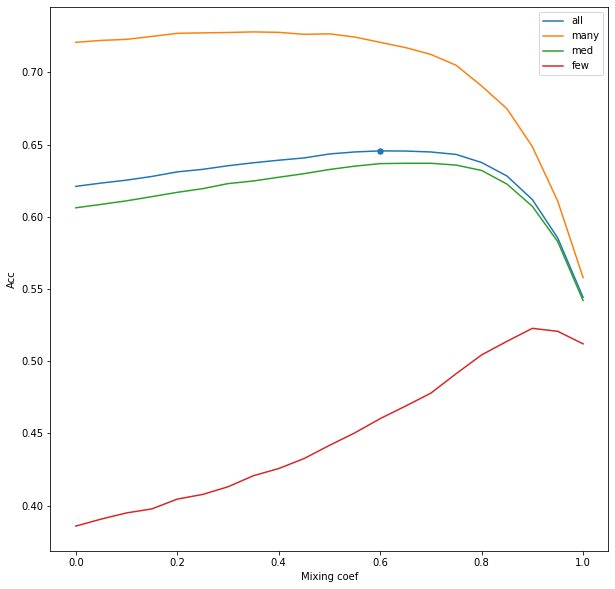

In [66]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
x = [i/20.0 for i in range(0, 21)]
m = np.argmax(test_accs_range)
sns.scatterplot(x = [x[m]], y = [test_accs_range[m]], marker='o', s=50)
ax = sns.lineplot(x = x, y = test_accs_range, label="all")
ax = sns.lineplot(x = x, y = many_accs_range, label="many")
ax = sns.lineplot(x = x, y = med_accs_range, label="med")
ax = sns.lineplot(x = x, y = few_accs_range, label="few")
ax.set(xlabel='Mixing coef', ylabel='Acc')
plt.show()

In [21]:
### Adaptively choose mixing coefficient using val set

# explore the confidence of prediction across the various mixtures

# Best Many:
i = 0.5
many_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
many_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
many_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

# Best Med:
i = 0.7
med_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
med_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
med_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

# Best Few:
i = 0.95
few_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
few_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
few_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_

acc = 0
for i in tqdm(range(50000)):
    if freqs[labels[i].item()] >= 100:
        pred = many_clf.predict(image_embeddings[i,:].unsqueeze(0))
    elif freqs[labels[i].item()] >= 20:
        pred = med_clf.predict(image_embeddings[i,:].unsqueeze(0))
    else:
        pred = few_clf.predict(image_embeddings[i,:].unsqueeze(0))
    if pred[0] == labels[i].item():
        acc+=1
        
print(acc/50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

0.6563


In [94]:
# Correlation between instance/class frequency and confidence of prediction - val

test_proba = image_only_clf_oversampled.predict_proba(image_embeddings_val)
test_proba_pred = np.max(test_proba, axis=-1)
test_acc = np.argmax(test_proba, axis=-1) == labels_val.numpy()
test_freqs = [freqs[i] for i in labels_val.numpy()]
inds = np.argsort(test_freqs)
test_freqs = np.array(test_freqs)[inds]
test_proba_pred = test_proba_pred[inds]
test_acc = test_acc[inds]

In [95]:
df = pd.DataFrame(list(zip(test_proba_pred, test_freqs, test_acc)),
               columns =['test_proba_pred', 'test_freqs', 'test_acc'])

/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='test_freqs', ylabel='test_proba_pred'>

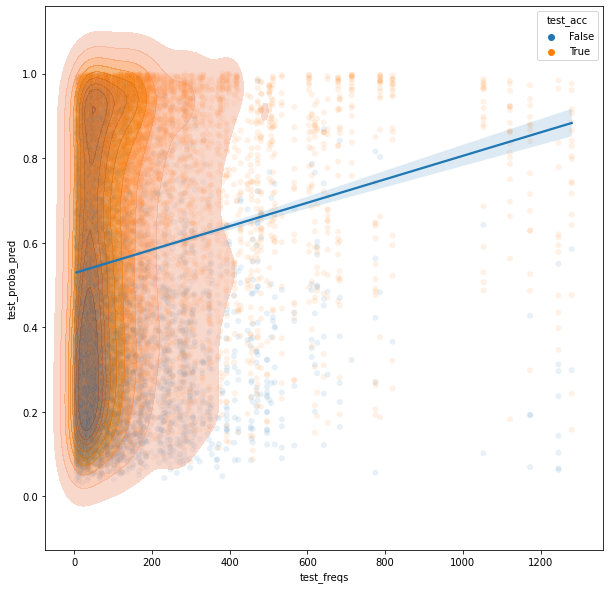

In [97]:
sns.scatterplot(data=df, x = 'test_freqs', y = 'test_proba_pred', alpha=0.1, hue='test_acc')
sns.regplot(data=df, x = 'test_freqs', y = 'test_proba_pred', scatter=False)
sns.kdeplot(data=df, x = "test_freqs", y = "test_proba_pred", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='test_freqs', ylabel='test_proba_pred'>

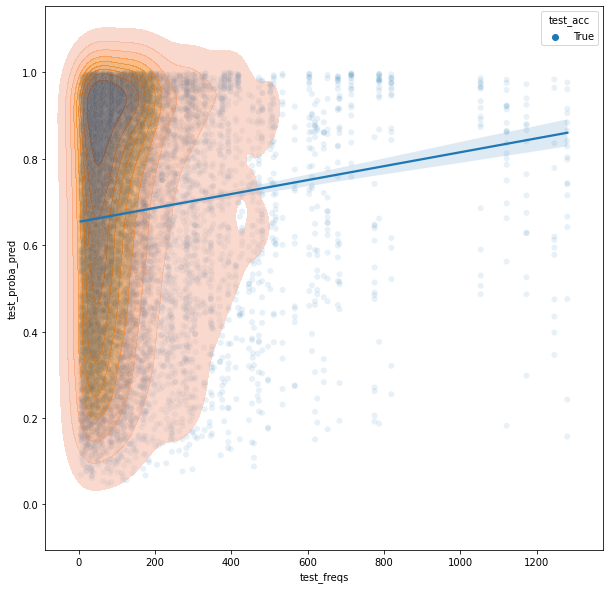

In [98]:
sns.scatterplot(data=df[test_acc == True], x = 'test_freqs', y = 'test_proba_pred', alpha=0.1, hue='test_acc')
sns.regplot(data=df[test_acc == True], x = 'test_freqs', y = 'test_proba_pred', scatter=False)
sns.kdeplot(data=df[test_acc == True], x = "test_freqs", y = "test_proba_pred", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='test_freqs', ylabel='test_proba_pred'>

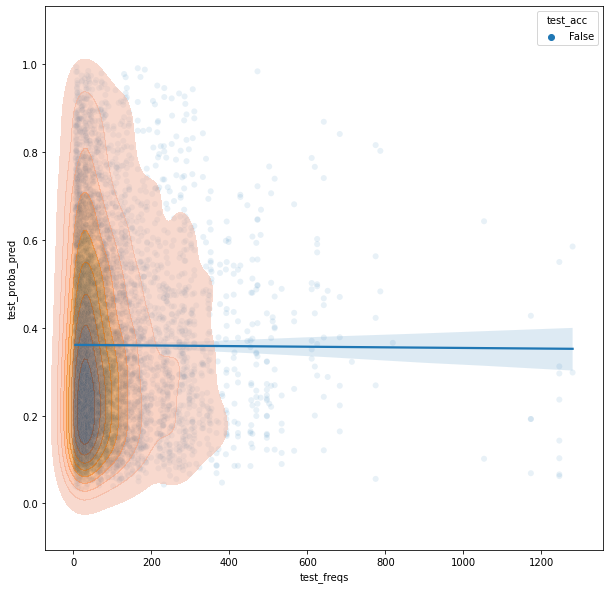

In [99]:
sns.scatterplot(data=df[test_acc == False], x = 'test_freqs', y = 'test_proba_pred', alpha=0.1, hue='test_acc')
sns.regplot(data=df[test_acc == False], x = 'test_freqs', y = 'test_proba_pred', scatter=False)
sns.kdeplot(data=df[test_acc == False], x = "test_freqs", y = "test_proba_pred", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)


In [22]:
def class_wise_accuracy(preds, labels):
    accs = np.zeros(1000)
    corr = preds == labels
    for i in range(len(labels)):
        if corr[i] == True:
            accs[labels[i]] +=1
    accs /= (len(labels)/1000)
    return accs

  0%|          | 0/21 [00:00<?, ?it/s]

<AxesSubplot:xlabel='freqs_per_class', ylabel='best_coefs_per_class'>

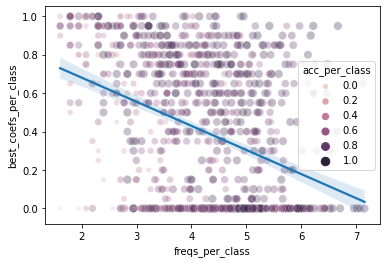

In [23]:
# Assess best coefficient per class

coefs = []
val_instance_preds = []
class_wise_accs = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
for i in tqdm(range(0, 21)):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings_val)
    cwa = class_wise_accuracy(preds, labels_val.numpy())
    class_wise_accs.append(cwa)
    val_instance_preds.append(preds)
    
coefs = np.array([i/20.0 for i in range(0, 21)])
indices_of_best_coefs = np.argmax(np.array(class_wise_accs), axis=0)

acc_per_class = np.max(np.array(class_wise_accs), axis=0)
best_coefs_per_class = np.array(coefs)[np.argmax(np.array(class_wise_accs), axis=0)]
freqs_per_class = np.log([freqs[i] for i in range(1000)])

df = pd.DataFrame(list(zip(best_coefs_per_class, freqs_per_class, acc_per_class)),
               columns =['best_coefs_per_class', 'freqs_per_class',  'acc_per_class'])

sns.scatterplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', hue='acc_per_class', size='acc_per_class', alpha=0.3)
sns.regplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', scatter=False)

In [24]:
np.mean(np.max(np.array(class_wise_accs), axis=0))

0.72075

  0%|          | 0/21 [00:00<?, ?it/s]

<AxesSubplot:xlabel='freqs_per_class', ylabel='best_coefs_per_class'>

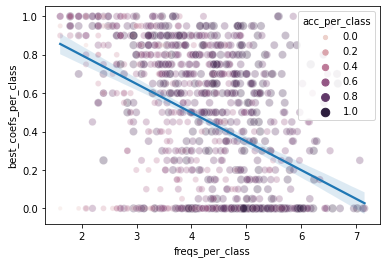

In [25]:
# Assess best coefficient per class

coefs = []
test_instance_preds = []
class_wise_accs_test = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
for i in tqdm(range(0, 21)):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings)
    cwa = class_wise_accuracy(preds, labels.numpy())
    class_wise_accs_test.append(cwa)
    test_instance_preds.append(preds)
    
coefs = np.array([i/20.0 for i in range(0, 21)])
indices_of_best_coefs = np.argmax(np.array(class_wise_accs), axis=0)

acc_per_class = np.max(np.array(class_wise_accs_test), axis=0)
best_coefs_per_class = np.array(coefs)[np.argmax(np.array(class_wise_accs_test), axis=0)]
freqs_per_class = np.log([freqs[i] for i in range(1000)])

df = pd.DataFrame(list(zip(best_coefs_per_class, freqs_per_class, acc_per_class)),
               columns =['best_coefs_per_class', 'freqs_per_class',  'acc_per_class'])

sns.scatterplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', hue='acc_per_class', size='acc_per_class', alpha=0.3)
sns.regplot(data=df, x = 'freqs_per_class', y = 'best_coefs_per_class', scatter=False)

In [26]:
np.mean(np.max(np.array(class_wise_accs_test), axis=0))

0.6997000000000001

In [134]:
class_wise_accs_test = class_wise_accs
indices_of_best_coefs

out = []
for i in range(1000):
    for j in indices_of_best_coefs:
        out.append(class_wise_accs_test[j][i])
        
np.mean(out)

0.6372135499999998

In [ ]:
### Adaptively choose mixing coefficient using val set

# explore the confidence of prediction across the various mixtures

# Best Many:
i = 0.45
many_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
many_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
many_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf.intercept_

# Best Med:
i = 0.8
med_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
med_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
med_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf.intercept_

# Best Few:
i = 0.95
few_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
few_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
few_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf.intercept_

acc = 0
for i in tqdm(range(50000)):
    if freqs[labels[i].item()] >= 100:
        pred = many_clf.predict(image_embeddings[i,:].unsqueeze(0))
    elif freqs[labels[i].item()] >= 20:
        pred = med_clf.predict(image_embeddings[i,:].unsqueeze(0))
    else:
        pred = few_clf.predict(image_embeddings[i,:].unsqueeze(0))
    if pred[0] == labels[i].item():
        acc+=1
        
print(acc/50000)

### Quantifying Agreement- varying # of iterations

#### V1

In [19]:
image_lp_iter_1 = pickle.load(open("results_sklearn/config_image_linear_probe_0/max_iter_1/13-Nov-2022-19-53-24/final_model.sav", 'rb'))
# all_accs(image_lp_iter_1)

In [20]:
image_lp_iter_5 = pickle.load(open("results_sklearn/config_image_linear_probe_0/max_iter_5/13-Nov-2022-22-14-28/final_model.sav", 'rb'))
# all_accs(image_lp_iter_5)

In [21]:
image_lp_iter_10 = pickle.load(open("results_sklearn/config_image_linear_probe_0/max_iter_10/13-Nov-2022-19-53-25/final_model.sav", 'rb'))
# all_accs(image_lp_iter_10)

In [22]:
image_lp_iter_50 = pickle.load(open("results_sklearn/config_image_linear_probe_0/max_iter_50/13-Nov-2022-19-53-23/final_model.sav", 'rb'))
# all_accs(image_lp_iter_50)


In [46]:
pred_list = [image_lp_iter_1.predict(image_embeddings), 
             image_lp_iter_5.predict(image_embeddings), 
             image_lp_iter_10.predict(image_embeddings), 
             image_lp_iter_50.predict(image_embeddings)]

In [50]:
disagreement = []
for preds in zip(*pred_list):
    disagreement.append(len(np.unique(preds)))
    
disagreement = np.array(disagreement)
print(len(disagreement))

diagreement_df = []
for i in range(1000):
    inds = np.where(labels.numpy() == i)
    num_disagreements = np.sum(disagreement[inds])
    diagreement_df.append([i, num_disagreements, np.log(freqs[i])])
    
diagreement_df = pd.DataFrame(diagreement_df, columns = ['label', 'num dsgrmnts', 'freq'])
diagreement_df

50000


,label,num dsgrmnts,freq
0,0,64,3.912023
1,1,64,5.521461
2,2,78,6.246107
3,3,68,5.863631
4,4,74,4.962845
...,...,...,...
995,995,68,5.117994
996,996,103,2.944439
997,997,83,3.218876
998,998,81,3.044522


In [86]:
plt.rcParams["figure.figsize"] = (20,20)

/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='freq', ylabel='num dsgrmnts'>

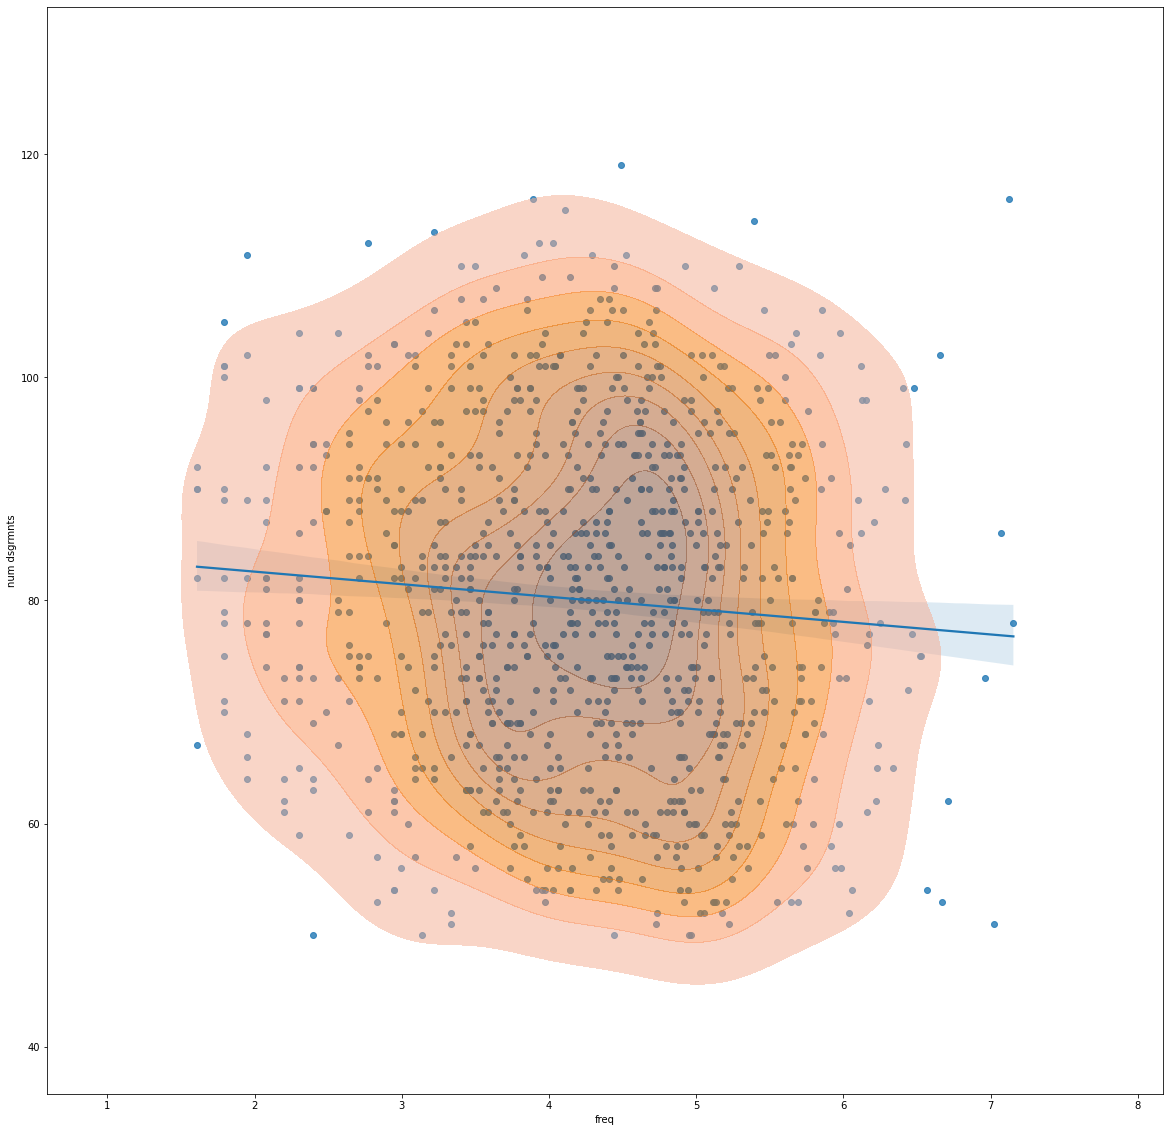

In [48]:


graph = sns.regplot(data=diagreement_df, x = "freq", y = "num dsgrmnts")
sns.kdeplot(data=diagreement_df, x = "freq", y = "num dsgrmnts", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)



#### V2

In [185]:
image_lp_iter_1 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_1/13-Nov-2022-22-37-28/final_model.sav", 'rb'))
all_accs(image_lp_iter_1)


KeyboardInterrupt: 

In [ ]:
image_lp_iter_5 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_5/13-Nov-2022-22-37-28/final_model.sav", 'rb'))
all_accs(image_lp_iter_5)


In [ ]:
image_lp_iter_10 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_10/13-Nov-2022-22-38-30/final_model.sav", 'rb'))
all_accs(image_lp_iter_10)


In [ ]:
image_lp_iter_15 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_15/14-Nov-2022-01-15-37/final_model.sav", 'rb'))
all_accs(image_lp_iter_15)


In [ ]:
image_lp_iter_20 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_20/14-Nov-2022-01-15-38/final_model.sav", 'rb'))
all_accs(image_lp_iter_20)


In [ ]:
image_lp_iter_25 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_25/13-Nov-2022-22-37-33/final_model.sav", 'rb'))
all_accs(image_lp_iter_25)

In [ ]:
image_lp_iter_30 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_30/14-Nov-2022-01-15-39/final_model.sav", 'rb'))
all_accs(image_lp_iter_30)



In [ ]:
image_lp_iter_35 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_35/14-Nov-2022-01-15-51/final_model.sav", 'rb'))
all_accs(image_lp_iter_35)

In [ ]:
image_lp_iter_45 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_45/14-Nov-2022-01-17-36/final_model.sav", 'rb'))
all_accs(image_lp_iter_45)

In [42]:
image_lp_iter_50 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_50/13-Nov-2022-22-38-31/final_model.sav", 'rb'))
# all_accs(image_lp_iter_50)

In [43]:
image_lp_iter_60 = pickle.load(open("results_sklearn/config_image_linear_probe_0/ub_max_iter_60/14-Nov-2022-01-16-38/final_model.sav", 'rb'))
# all_accs(image_lp_iter_60)

In [44]:
image_lp_iter_max = pickle.load(open("results_sklearn/config_image_linear_probe_0/c_62/13-Sep-2022-13-38-17/final_model.sav", 'rb'))
# all_accs(image_lp_iter_max)



In [45]:
pred_list = [image_lp_iter_1.predict(image_embeddings), 
             image_lp_iter_5.predict(image_embeddings), 
             image_lp_iter_10.predict(image_embeddings),
             image_lp_iter_15.predict(image_embeddings),
             image_lp_iter_20.predict(image_embeddings),
             image_lp_iter_25.predict(image_embeddings),
             image_lp_iter_30.predict(image_embeddings),
             image_lp_iter_35.predict(image_embeddings),
             image_lp_iter_45.predict(image_embeddings),
             image_lp_iter_50.predict(image_embeddings),
             image_lp_iter_60.predict(image_embeddings),
             image_lp_iter_max.predict(image_embeddings),
            ]

In [188]:
[all_accs_p(ps) for ps in pred_list]

0.004/0.009/0.000/0.000
0.056/0.144/0.000/0.000
0.134/0.342/0.000/0.000
0.262/0.606/0.053/0.000
0.300/0.652/0.095/0.000
0.354/0.679/0.187/0.000
0.398/0.697/0.261/0.015
0.437/0.718/0.325/0.018
0.497/0.735/0.431/0.044
0.515/0.736/0.460/0.074
0.538/0.743/0.484/0.134
0.561/0.751/0.504/0.211


[[0.00366, 0.009360613810741688, 0.0, 0.0],
 [0.0564, 0.1442455242966752, 0.0, 0.0],
 [0.1339, 0.3423529411764706, 8.456659619450317e-05, 0.0],
 [0.26184, 0.6057800511508952, 0.05281183932346723, 0.0],
 [0.29996, 0.6520716112531969, 0.09513742071881606, 0.0],
 [0.35422, 0.6794373401534527, 0.18723044397463, 0.0],
 [0.39814, 0.6968286445012788, 0.26139534883720933, 0.015],
 [0.43694, 0.718005115089514, 0.32520084566596197, 0.0175],
 [0.49742, 0.7350383631713555, 0.4312896405919662, 0.04426470588235294],
 [0.5155, 0.7360102301790281, 0.46029598308668074, 0.07352941176470588],
 [0.5377, 0.7433248081841433, 0.4836786469344609, 0.13441176470588234],
 [0.56074, 0.7512531969309463, 0.5038900634249471, 0.21073529411764705]]

In [46]:
pred_list_val = [image_lp_iter_1.predict(image_embeddings_val), 
             image_lp_iter_5.predict(image_embeddings_val), 
             image_lp_iter_10.predict(image_embeddings_val),
             image_lp_iter_15.predict(image_embeddings_val),
             image_lp_iter_20.predict(image_embeddings_val),
             image_lp_iter_25.predict(image_embeddings_val),
             image_lp_iter_30.predict(image_embeddings_val),
             image_lp_iter_35.predict(image_embeddings_val),
             image_lp_iter_45.predict(image_embeddings_val),
             image_lp_iter_50.predict(image_embeddings_val),
             image_lp_iter_60.predict(image_embeddings_val),
             image_lp_iter_max.predict(image_embeddings_val),
            ]

In [87]:
disagreement = []
for preds in zip(*pred_list):
    disagreement.append(len(np.unique(preds)))
    
disagreement = np.array(disagreement)
print(len(disagreement))

diagreement_df = []
for i in range(1000):
    inds = np.where(labels.numpy() == i)
    num_disagreements = np.sum(disagreement[inds])/50.0
    diagreement_df.append([i, num_disagreements, np.log(freqs[i])])
    
diagreement_df = pd.DataFrame(diagreement_df, columns = ['label', 'num dsgrmnts', 'freq'])
diagreement_df

50000


,label,num dsgrmnts,freq
0,0,4.96,3.912023
1,1,2.74,5.521461
2,2,2.78,6.246107
3,3,3.34,5.863631
4,4,3.70,4.962845
...,...,...,...
995,995,3.12,5.117994
996,996,4.26,2.944439
997,997,3.08,3.218876
998,998,3.52,3.044522


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='freq', ylabel='num dsgrmnts'>

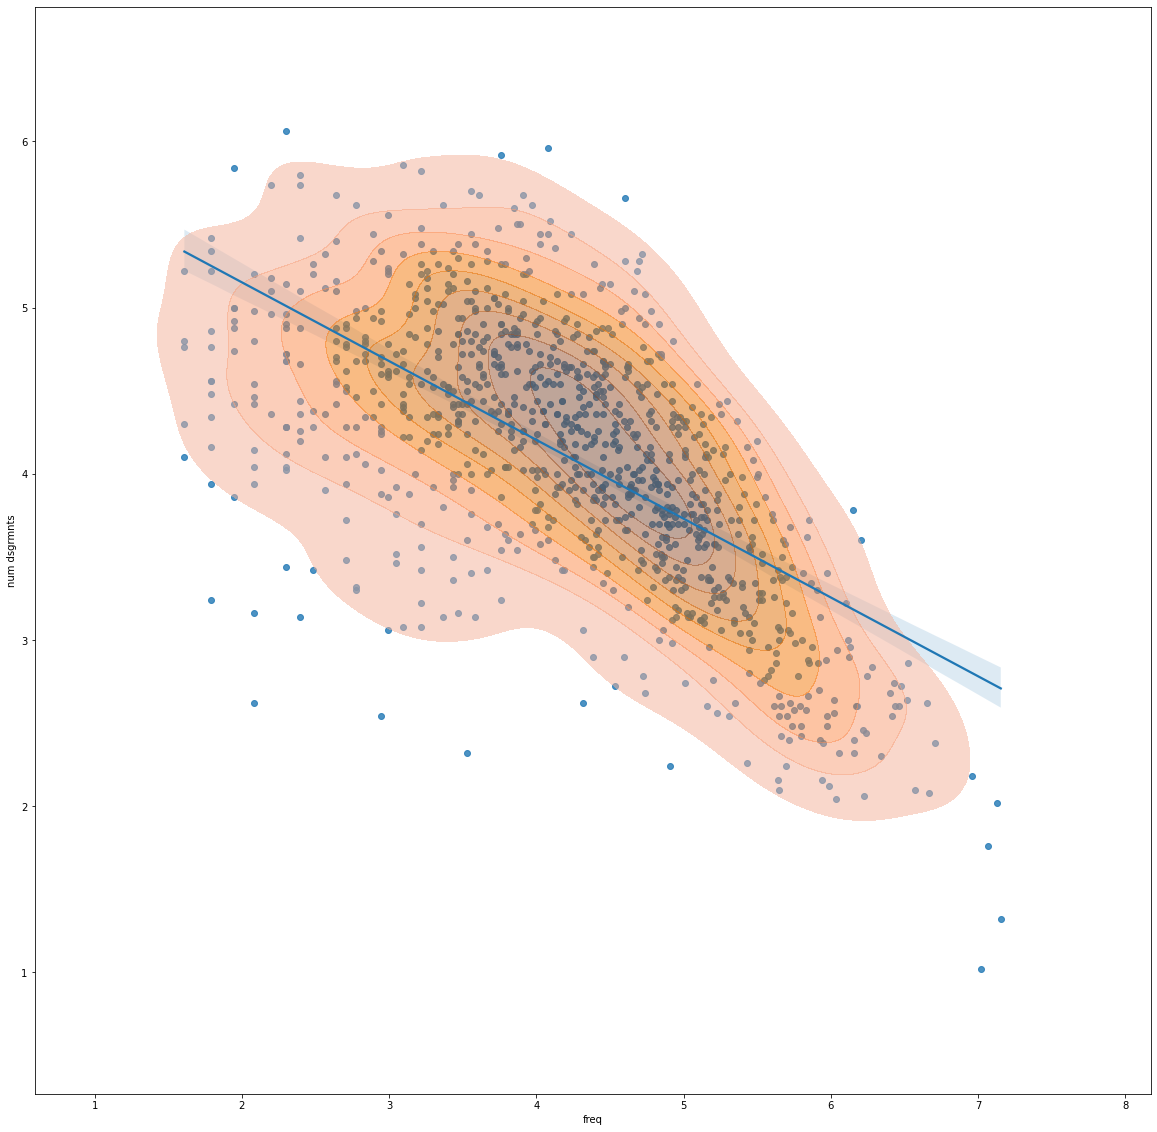

In [88]:
plt.rcParams["figure.figsize"] = (20,20)

graph = sns.regplot(data=diagreement_df, x = "freq", y = "num dsgrmnts")
sns.kdeplot(data=diagreement_df, x = "freq", y = "num dsgrmnts", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)



In [89]:
disagreement = []
for preds in zip(*pred_list_val):
    disagreement.append(len(np.unique(preds)))
    
disagreement = np.array(disagreement)
print(len(disagreement))

diagreement_df = []
for i in range(1000):
    inds = np.where(labels_val.numpy() == i)
    num_disagreements = np.sum(disagreement[inds])/50.0
    diagreement_df.append([i, num_disagreements, np.log(freqs[i])])
    
diagreement_df = pd.DataFrame(diagreement_df, columns = ['label', 'num dsgrmnts', 'freq'])
diagreement_df

20000


,label,num dsgrmnts,freq
0,0,1.94,3.912023
1,1,0.96,5.521461
2,2,1.06,6.246107
3,3,1.30,5.863631
4,4,1.54,4.962845
...,...,...,...
995,995,1.28,5.117994
996,996,1.68,2.944439
997,997,1.02,3.218876
998,998,1.74,3.044522


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='freq', ylabel='num dsgrmnts'>

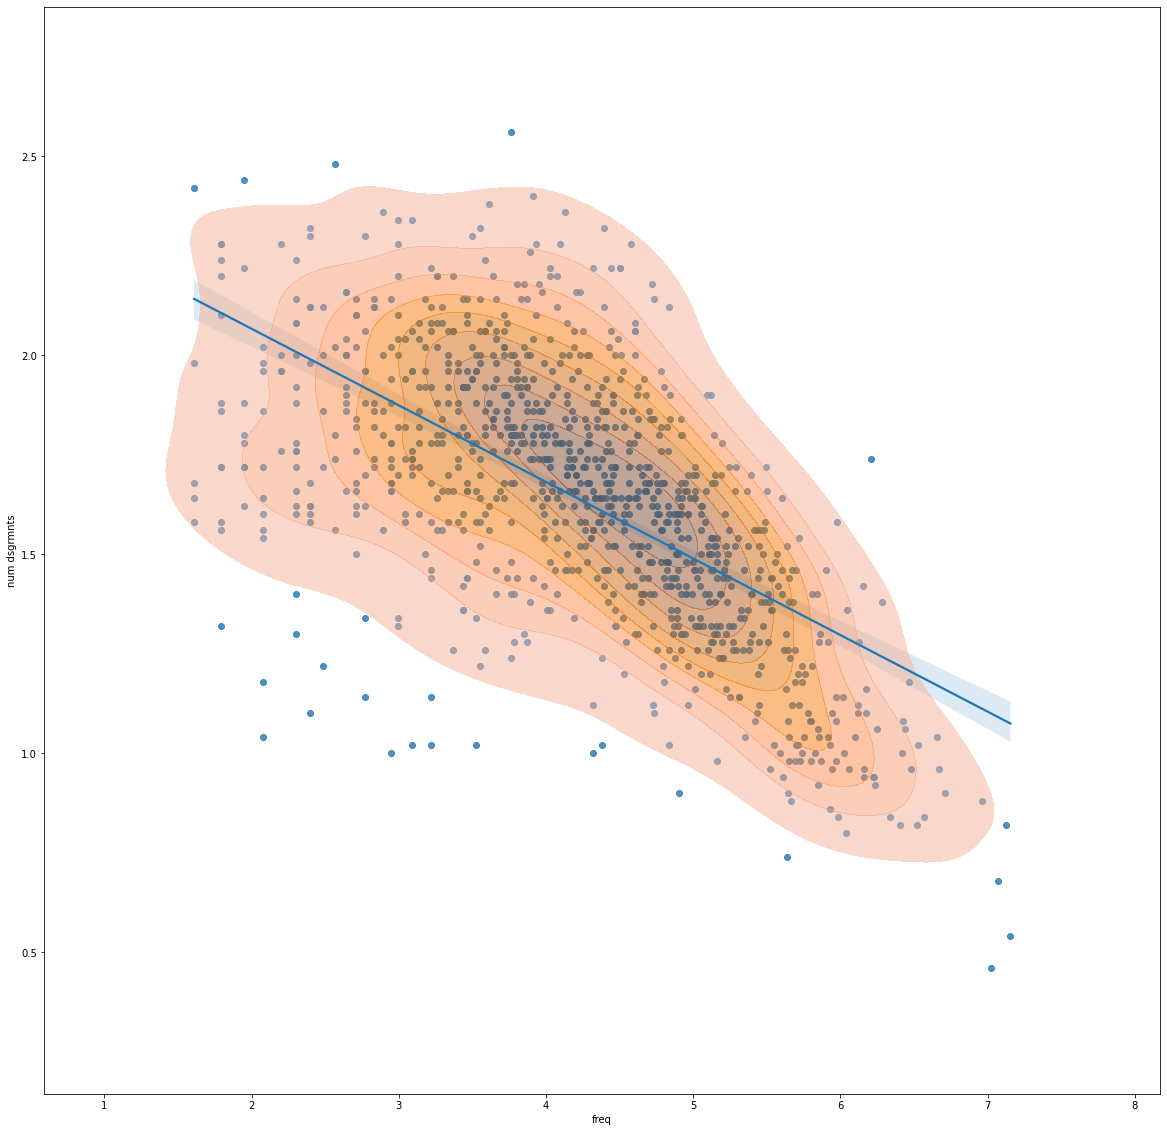

In [90]:
plt.rcParams["figure.figsize"] = (20,20)

graph = sns.regplot(data=diagreement_df, x = "freq", y = "num dsgrmnts")
sns.kdeplot(data=diagreement_df, x = "freq", y = "num dsgrmnts", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)



In [92]:
disagreement = []
for preds in zip(*pred_list_val):
    disagreement.append(len(np.unique(preds)))
    
disagreement = np.array(disagreement)
print(len(disagreement))

diagreement_df = []
coefs = np.array([i/20.0 for i in range(0, 21)])
for i, z in tqdm(enumerate(zip(*val_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels_val[i].item())[0]
    for c in coefs[inds]:
        num_disagreements = disagreement[i]
        diagreement_df.append([labels_val[i].item(), num_disagreements, np.log(freqs[labels_val[i].item()]), c])
    
diagreement_df = pd.DataFrame(diagreement_df, columns = ['label', 'num dsgrmnts', 'freq', "coefs"])
diagreement_df

20000


0it [00:00, ?it/s]

,label,num dsgrmnts,freq,coefs
0,329,2,6.100319,0.00
1,329,2,6.100319,0.05
2,329,2,6.100319,0.10
3,329,2,6.100319,0.15
4,329,2,6.100319,0.20
...,...,...,...,...
268680,324,4,4.394449,0.80
268681,324,4,4.394449,0.85
268682,324,4,4.394449,0.90
268683,324,4,4.394449,0.95


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='num dsgrmnts', ylabel='coefs'>

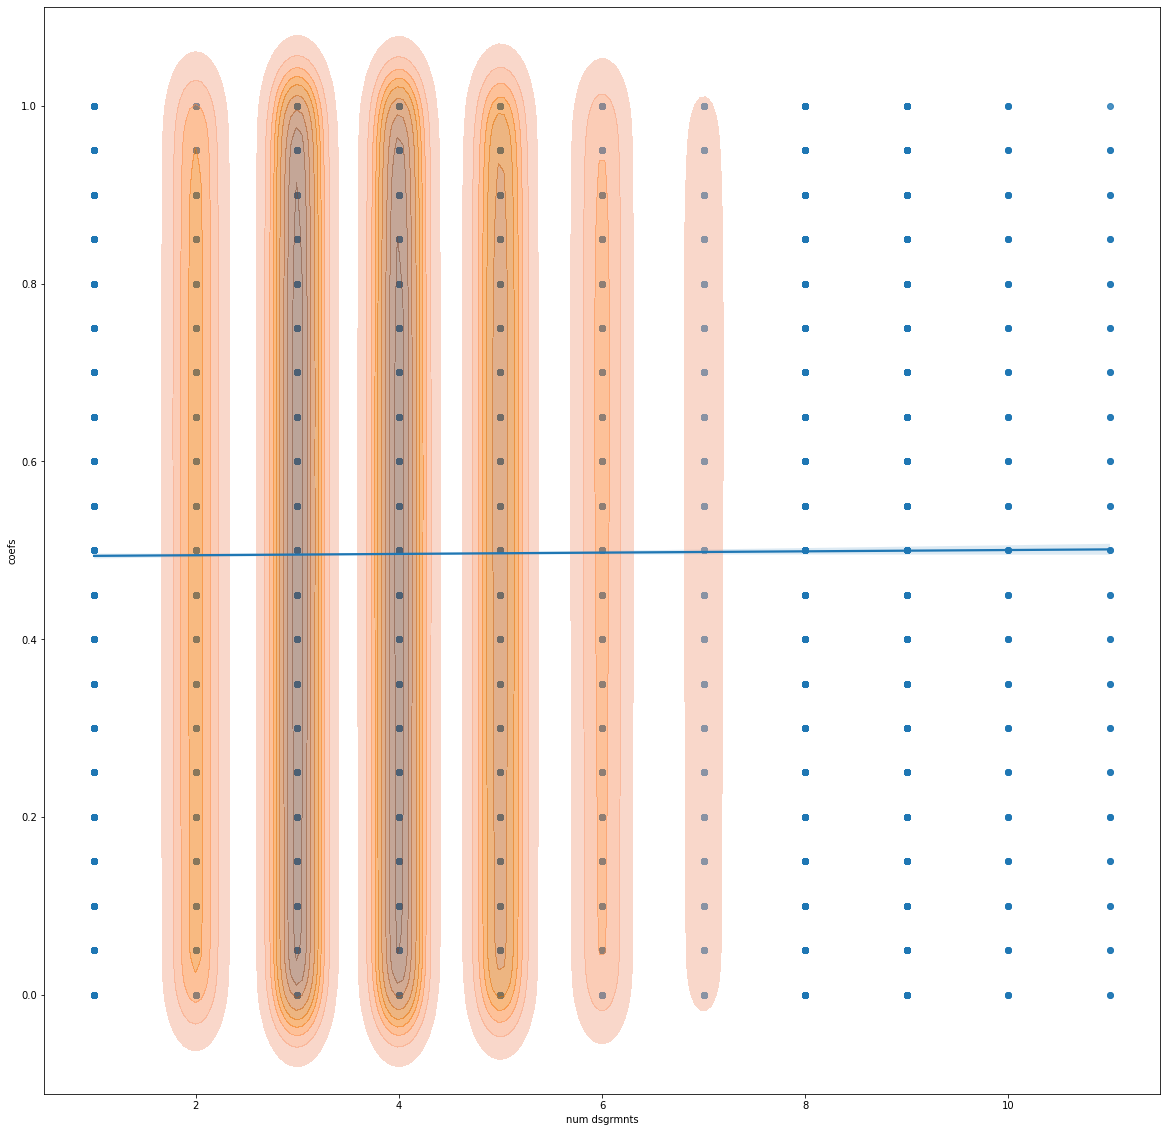

In [95]:
plt.rcParams["figure.figsize"] = (20,20)

graph = sns.regplot(data=diagreement_df, y = "coefs", x = "num dsgrmnts")
sns.kdeplot(data=diagreement_df, y = "coefs", x = "num dsgrmnts", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='freq', ylabel='coefs'>

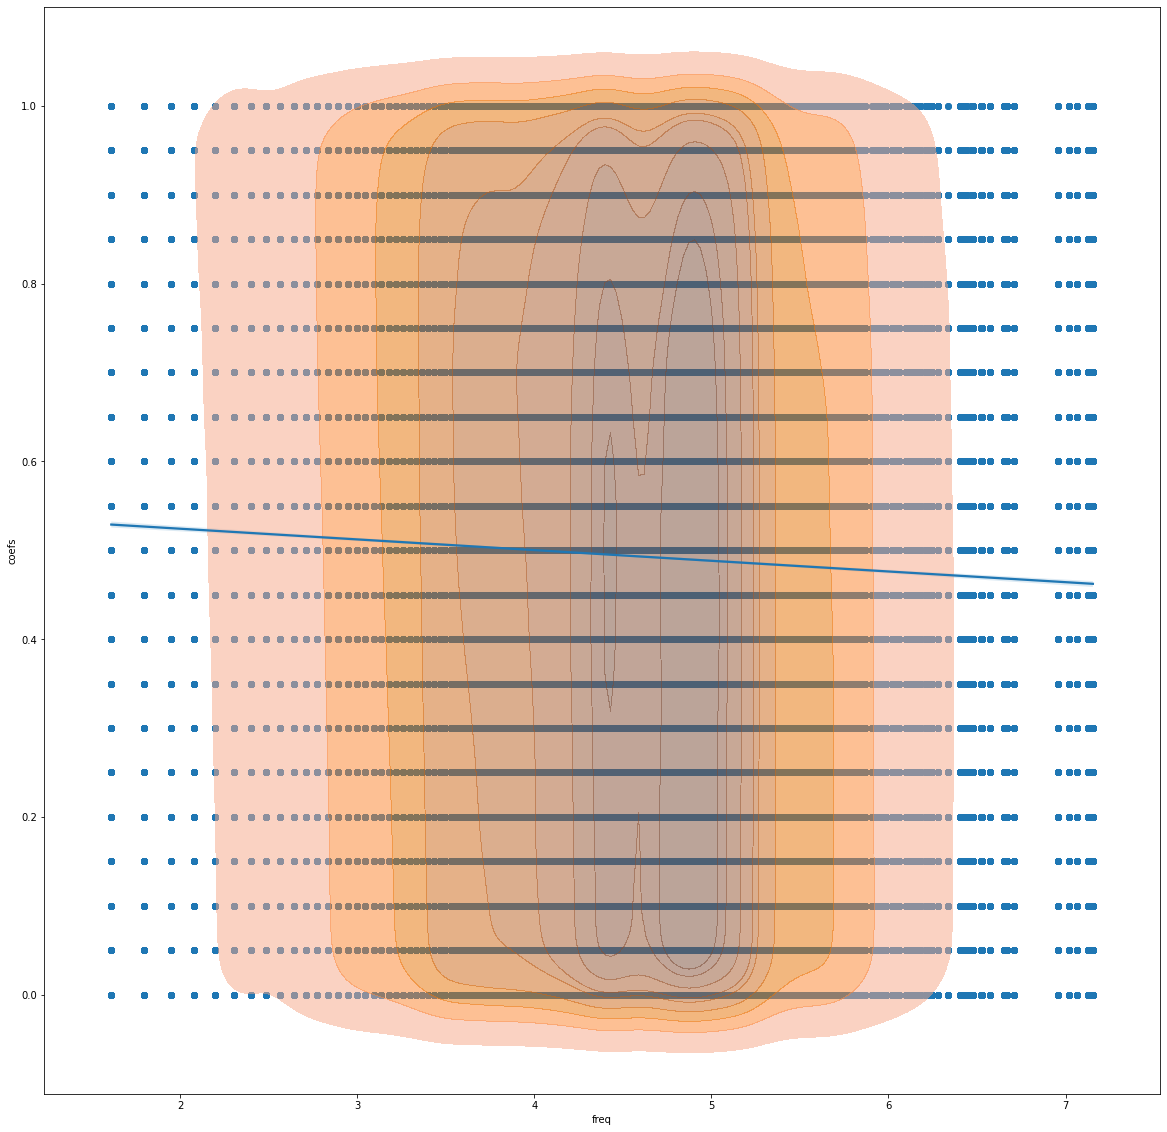

In [96]:
plt.rcParams["figure.figsize"] = (20,20)

graph = sns.regplot(data=diagreement_df, y = "coefs", x = "freq")
sns.kdeplot(data=diagreement_df, y = "coefs", x = "freq", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)


(0.0, 1.0)

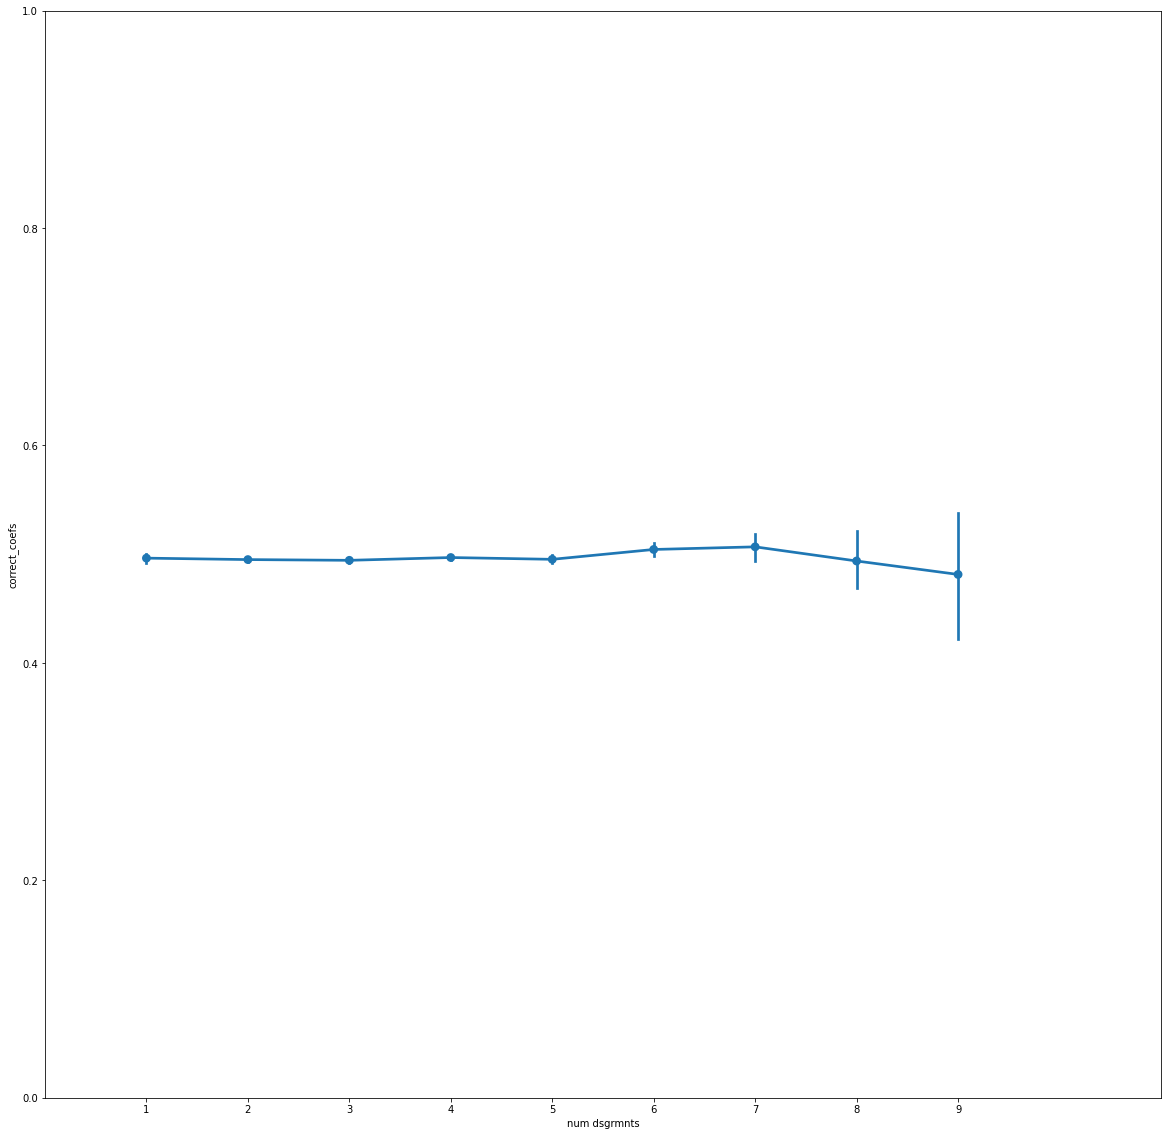

In [218]:
blah = lambda x: (x.min(), x.max())
graph = sns.pointplot(data=df_corr_det, x = "num dsgrmnts", y = "correct_coefs", errorbar=None)
plt.xlim([-1, 10])
plt.ylim([0, 1])

In [219]:
sns.plotpoint?

Object `sns.plotpoint` not found.


In [97]:
disagreement = []
for preds in zip(*pred_list):
    disagreement.append(len(np.unique(preds)))
print(len(disagreement))

df_corr = []
df_corr_det = []
acc_preds = []

best_possible_acc = 0
for i, z in tqdm(enumerate(zip(*test_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels[i].item())[0]
    if len(inds) > 0 :
        best_possible_acc+=1
        correct_coefs = coefs[inds]
        acc_preds.append(labels[i].item())
    else:
        correct_coefs = []
        acc_preds.append(labels[i].item()+1)
    f = freqs[labels[i].item()]
    d = disagreement[i]
    df_corr.append([correct_coefs, f, d, np.mean(correct_coefs), np.std(correct_coefs)])
    for c in correct_coefs:
        df_corr_det.append([c, f, d])
    
df_corr = pd.DataFrame(df_corr, columns = ['correct_coefs', 'freq', 'num dsgrmnts', 'best_coef', 'best_coef_std'])
df_corr = df_corr.dropna()
df_corr_det = pd.DataFrame(df_corr_det, columns = ['correct_coefs', 'freq', 'num dsgrmnts'])
df_corr_det = df_corr_det.dropna()
df_corr_det

50000


0it [00:00, ?it/s]

/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  

,correct_coefs,freq,num dsgrmnts
0,0.00,51,6
1,0.05,51,6
2,0.10,51,6
3,0.15,51,6
4,0.20,51,6
...,...,...,...
659476,0.80,173,4
659477,0.85,173,4
659478,0.90,173,4
659479,0.95,173,4


In [98]:
best_possible_acc/50000.0

0.73978

In [100]:
all_accs_p(np.array(acc_preds))

0.740/0.791/0.731/0.623


[0.73978, 0.7909462915601023, 0.7311205073995771, 0.6227941176470588]

In [ ]:
graph = sns.pointplot(data=df_corr_det, x = "num dsgrmnts", y = "correct_coefs", alpha = 0.1)

graph = sns.scatterplot(data=df_corr_det, x = "num dsgrmnts", y = "correct_coefs", alpha = 0.1)
blah = df_corr_det
# graph = sns.kdeplot(data=blah, x = "num dsgrmnts", y = "correct_coefs", fill=True, common_norm=False, palette="crest", alpha=.5)

plt.xlim([-1, 10])
plt.ylim([-1, 1])

In [249]:
df_corr_det[df_corr_det["num dsgrmnts"] == 10]

,correct_coefs,freq,num dsgrmnts


In [274]:
disagreement_test = []
for preds in zip(*pred_list):
    disagreement_test.append(len(np.unique(preds)))
print(len(disagreement_test))

disagreement_val = []
for preds in zip(*pred_list_val):
    disagreement_val.append(len(np.unique(preds)))
print(len(disagreement_val))

50000
20000


### Train a Linear layer to predict mixing coefficients 

In [169]:
from sklearn.linear_model import LinearRegression

#### 1. Only Image Linear Probe scores

In [170]:
indices = [] # indices corresponding to coefs
corr_coefs = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*val_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels_val[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        indices.append(i)
        corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
#         print(correct_coefs)
    else:
        correct_coefs = []
        
#     for c in correct_coefs:
#         coef_labels.append(i)
#         corr_coefs.append(c)
        
indices = np.array(indices)
targets = np.array(corr_coefs)

print(len(indices), len(corr_coefs))

0it [00:00, ?it/s]

15009 15009


In [171]:
scores = image_lp_iter_max.predict_proba(image_embeddings_val)
inps = scores[indices, :]
print(inps.shape)
print(targets.shape)

(15009, 1000)
(15009, 2)


In [62]:
test_indices = [] # indices corresponding to coefs
test_corr_coefs = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*test_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        test_indices.append(i)
        test_corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
#         print(correct_coefs)
    else:
        correct_coefs = []
        
#     for c in correct_coefs:
#         coef_labels.append(i)
#         corr_coefs.append(c)
        
test_indices = np.array(test_indices)
test_targets = np.array(test_corr_coefs)

print(len(test_indices), len(test_corr_coefs))

test_scores = image_lp_iter_max.predict_proba(image_embeddings)
test_inputs = test_scores[test_indices, :]

0it [00:00, ?it/s]

36989 36989
(50000, 1000)


In [121]:
import torch
import torch.nn as nn

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) 
        self.m = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.m(out)
        return out
    
def overlap_loss(output, target):
    mse = nn.MSELoss()
#     start1 = output[:,0] - output[:,1]
#     start2 = torch.max(target[:,0] - target[:,1],start1)
#     end1 = output[:,0] + output[:,1]
#     end2 = torch.min(target[:,0] + target[:,1], end1)
#     mask = target[:,1] < output[:,1]
#     filtered_targets = target[:,1]

    loss1 = mse(output[:,0],target[:,0])
    loss2 = mse(output[:,1],target[:,1])
    return loss1 + loss2

model = LinearRegressionModel(1000, 2)
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 1000
for epoch in range(epochs):
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(inps).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = overlap_loss(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    
    if epoch%100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        
test_coef_preds = model(torch.from_numpy(test_scores).float())
test_coef_preds.shape

In [ ]:
# Test model on test instances

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

acc = 0

for j in tqdm(range(test_coef_preds.shape[0])):
    i = test_coef_preds[j][0].item()
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    pred = mixed_clf.predict(image_embeddings[j].reshape(1, -1) )
#     print(test_coef_preds[j,:])
    print(pred, labels[j])
    print(i)
    break

In [147]:
test_coef_preds = model(torch.from_numpy(test_scores).float())
test_coef_preds.shape

torch.Size([50000, 2])

In [181]:
# Baseline

# Best Val
# Mixing coeff: 0.65
# 0.65785

# Best Test

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

acc = 0

i = 0.65
mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
all_accs(mixed_clf)

0.646/0.717/0.637/0.469


[0.64554, 0.7171867007672634, 0.6370824524312897, 0.46897058823529414]

In [180]:
# Test model on test instances


mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

acc = 0

preds = []
for j in tqdm(range(test_coef_preds.shape[0])):
    i = test_coef_preds[j][0].item()
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    pred = mixed_clf.predict(image_embeddings[j].reshape(1, -1))
    preds.append(pred[0])
    if pred[0] == labels[j].item():
        acc+=1
    if j>0 and j%1000 == 0:
        print(acc*100/j)
preds = np.array(preds)
all_accs_p(preds)

  0%|          | 0/50000 [00:00<?, ?it/s]

62.7
63.6
63.833333333333336
63.975
63.94
63.78333333333333
64.14285714285714
64.1875
64.0
63.88
63.81818181818182
63.78333333333333
63.88461538461539
64.00714285714285
64.14666666666666
64.1375
64.17647058823529
64.4
64.34210526315789
64.355
64.3952380952381
64.53636363636363
64.59130434782608
64.475
64.4
64.4076923076923
64.42962962962963
64.41785714285714
64.37586206896552
64.48
64.47096774193548
64.503125
64.46969696969697
64.47058823529412
64.47428571428571
64.3861111111111
64.35405405405406
64.41578947368421
64.46153846153847
64.475
64.48048780487805
64.52857142857142
64.57674418604651
64.55909090909091
64.54444444444445
64.55
64.49148936170212
64.48541666666667
64.45714285714286
0.645/0.725/0.634/0.452


[0.64462, 0.7247570332480818, 0.6338689217758985, 0.4516176470588235]

##### 1.2 Change loss function

In [228]:
import torch
import torch.nn as nn

    
def overlap_loss(output, target):
    mse = nn.MSELoss()
    start1 = output[:,0] - output[:,1]
    start2 = target[:,0] - target[:,1]
    end1 = output[:,0] + output[:,1]
    end2 = target[:,0] + target[:,1]
    intersection = torch.abs(torch.max(start1, start2) - torch.min(end1, end2))
    union = torch.abs(torch.min(start1, start2) - torch.max(end1, end2))
    loss = mse(union,intersection)
    return loss

model = LinearRegressionModel(1000, 2)
learning_rate = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

epochs = 2000
for epoch in range(epochs):
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(inps).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = overlap_loss(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    
    if epoch%100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

train_coef_preds = model(torch.from_numpy(scores).float())
test_coef_preds.shape        
test_coef_preds = model(torch.from_numpy(test_scores).float())
test_coef_preds.shape

epoch 0, loss 0.102133609354496
epoch 100, loss 0.08661315590143204
epoch 200, loss 0.08585432916879654
epoch 300, loss 0.08563925325870514
epoch 400, loss 0.08552423864603043
epoch 500, loss 0.08544377982616425
epoch 600, loss 0.08539923280477524
epoch 700, loss 0.08536317199468613
epoch 800, loss 0.08533242344856262
epoch 900, loss 0.08530935645103455
epoch 1000, loss 0.08529216051101685
epoch 1100, loss 0.08527139574289322
epoch 1200, loss 0.08525564521551132
epoch 1300, loss 0.08524139970541
epoch 1400, loss 0.08523257076740265
epoch 1500, loss 0.08521714061498642
epoch 1600, loss 0.08520946651697159
epoch 1700, loss 0.08520291745662689
epoch 1800, loss 0.08519606292247772
epoch 1900, loss 0.08518675714731216


torch.Size([50000, 2])

In [229]:
# Test model on val instances


mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

acc = 0

preds = []
for j in tqdm(range(train_coef_preds.shape[0])):
    i = train_coef_preds[j][0].item() 
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    pred = mixed_clf.predict(image_embeddings_val[j].reshape(1, -1))
    preds.append(pred[0])
    if pred[0] == labels_val[j].item():
        acc+=1
    if j>0 and j%1000== 0:
        print(acc*100/j)
print(acc*100/j)
# preds = np.array(preds)
# all_accs_p(preds)

  0%|          | 0/20000 [00:00<?, ?it/s]

65.2
64.8
64.53333333333333
64.5
65.16
65.25
64.77142857142857
64.6625
64.42222222222222
64.58
64.72727272727273
64.84166666666667
64.93076923076923
64.82142857142857
64.91333333333333
65.1875
65.37058823529412
65.33888888888889
65.45263157894736
65.47327366368319


In [197]:
# Test model on test instances


mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

acc = 0

preds = []
for j in tqdm(range(test_coef_preds.shape[0])):
    i = test_coef_preds[j][0].item()
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    pred = mixed_clf.predict(image_embeddings[j].reshape(1, -1))
    preds.append(pred[0])
    if pred[0] == labels[j].item():
        acc+=1
    if j>0 and j%1000 == 0:
        print(acc*100/j)
preds = np.array(preds)
all_accs_p(preds)

  0%|          | 0/50000 [00:00<?, ?it/s]

62.8
63.7
63.86666666666667
64.0
63.96
63.8
64.15714285714286
64.2
64.02222222222223
63.9
63.836363636363636
63.8
63.9
64.02857142857142
64.16666666666667
64.1625
64.2
64.41666666666667
64.3578947368421
64.375
64.41428571428571
64.55454545454545
64.6086956521739
64.49583333333334
64.42
64.41923076923077
64.44074074074074
64.43214285714286
64.3896551724138
64.49
64.48064516129033
64.5125
64.47878787878788
64.48235294117647
64.48571428571428
64.39722222222223
64.36756756756756
64.42894736842105
64.47948717948718
64.495
64.49756097560976
64.54523809523809
64.59302325581395
64.575
64.56
64.56521739130434
64.50638297872341
64.5
64.47142857142858
0.645/0.725/0.634/0.452


[0.64476, 0.7249616368286445, 0.633953488372093, 0.45176470588235296]

##### 1.3 Add disagreements as feature

In [390]:
indices = [] # indices corresponding to coefs
corr_coefs = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*val_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels_val[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        indices.append(i)
        corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs), ])
        
indices = np.array(indices)
corr_coefs = np.array(corr_coefs)

print(len(indices), len(corr_coefs))

0it [00:00, ?it/s]

15009 15009


In [391]:
scores = image_lp_iter_max.predict_proba(image_embeddings_val)
scores.shape

(20000, 1000)

In [392]:
import sklearn
text_scores_val = sklearn.metrics.pairwise.cosine_similarity(image_embeddings_val.cpu(),text_embs.cpu())
text_scores.shape

(20000, 1000)

In [393]:
disagreement_val = np.array(disagreement_val).reshape(-1,1)
print(disagreement_val.shape)
print(scores.shape)
print(text_scores_val.shape)
scores = np.concatenate((scores,disagreement_val, text_scores_val), axis=-1)
scores.shape

(20000, 1)
(20000, 1000)
(20000, 1000)


(20000, 2001)

In [394]:
inps = scores[indices, :]
print(inps.shape)
print(targets.shape)

(15009, 2001)
torch.Size([15009, 1])


In [395]:
test_indices = [] # indices corresponding to coefs
test_corr_coefs = [] # coefs corresponding to input

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*test_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels[i].item())[0]
    if len(inds) > 0 :
        correct_coefs = coefs[inds]
        test_indices.append(i)
        test_corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
        
test_indices = np.array(test_indices)
test_targets = np.array(test_corr_coefs)

print(len(test_indices), len(test_corr_coefs))

0it [00:00, ?it/s]

36989 36989


In [396]:
import sklearn
text_scores_test = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(),text_embs.cpu())
text_scores_test.shape

(50000, 1000)

In [397]:
test_scores = image_lp_iter_max.predict_proba(image_embeddings)
disagreement_test = np.array(disagreement_test).reshape(-1,1)
print(disagreement_test.shape)
test_scores = np.concatenate((test_scores,disagreement_test, text_scores_test), axis=-1)
test_inputs = test_scores[test_indices, :]
print(test_scores.shape)
print(test_inputs.shape)

(50000, 1)
(50000, 2001)
(36989, 2001)


In [ ]:
inps_ = inps[:, 0:2001]
scores_ = scores[:, 0:2001]
test_scores_ = test_scores[:, 0:2001]

In [419]:
import torch
import torch.nn as nn

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 100)
        self.bn = nn.LayerNorm(100)
#         self.do = nn.Dropout(p=0.05)
        self.linear2 = nn.Linear(100, output_dim)
        self.m = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.linear2(x)
        out = self.m(x)
        return out
    
# def overlap_loss(output, target):
#     mse = nn.MSELoss()
#     start1 = output[:,0] - output[:,1]
#     start2 = target[:,0] - target[:,1]
#     end1 = output[:,0] + output[:,1]
#     end2 = target[:,0] + target[:,1]
#     intersection = torch.abs(torch.max(start1, start2) - torch.min(end1, end2))
#     union = torch.abs(torch.min(start1, start2) - torch.max(end1, end2))
#     loss = mse(union,intersection)
#     return loss

def overlap_loss(output, target):
    mse = nn.MSELoss()

#     loss1 = mse(output[:,0],target[:,0])
    loss1 = mse(output,target)
    return loss1

epochs = 5000
model = LinearRegressionModel(2001, 2)
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)


for epoch in range(epochs):
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(inps_).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = overlap_loss(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()
    
    if epoch%100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        
train_coef_preds = model(torch.from_numpy(scores_).float())
test_coef_preds.shape        
test_coef_preds = model(torch.from_numpy(test_scores_).float())
test_coef_preds.shape

epoch 0, loss 0.05999714881181717
epoch 100, loss 0.019980300217866898
epoch 200, loss 0.01934739015996456
epoch 300, loss 0.018716441467404366
epoch 400, loss 0.018241407349705696
epoch 500, loss 0.017968017607927322
epoch 600, loss 0.01782802678644657
epoch 700, loss 0.017755484208464622
epoch 800, loss 0.017708858475089073
epoch 900, loss 0.017672099173069
epoch 1000, loss 0.01763947866857052
epoch 1100, loss 0.01760845072567463
epoch 1200, loss 0.017577502876520157
epoch 1300, loss 0.0175454244017601
epoch 1400, loss 0.01751095801591873
epoch 1500, loss 0.01747250184416771
epoch 1600, loss 0.017427485436201096
epoch 1700, loss 0.01737016625702381
epoch 1800, loss 0.017289133742451668
epoch 1900, loss 0.017264848574995995
epoch 2000, loss 0.017518552020192146
epoch 2100, loss 0.017135338857769966
epoch 2200, loss 0.017215237021446228
epoch 2300, loss 0.016981512308120728
epoch 2400, loss 0.01699749194085598
epoch 2500, loss 0.017416710034012794
epoch 2600, loss 0.01740950718522072
e

torch.Size([50000, 2])

In [420]:
train_coef_preds = model(torch.from_numpy(scores_).float())
test_coef_preds.shape        
test_coef_preds = model(torch.from_numpy(test_scores_).float())
test_coef_preds.shape

torch.Size([50000, 2])

In [421]:
# Test model on val instances

def evaluate_acc_on_val(train_coef_preds):
    mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

    acc = 0

    preds = []
    for j in tqdm(range(train_coef_preds.shape[0])):
        i = train_coef_preds[j][0].item() 
        mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
        mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
        pred = mixed_clf.predict(image_embeddings_val[j].reshape(1, -1))
        preds.append(pred[0])
        if pred[0] == labels_val[j].item():
            acc+=1
        if j>0 and j%1000== 0:
            print(j, acc*100/j)
    print(acc*100/j)
    
evaluate_acc_on_val(train_coef_preds)
# preds = np.array(preds)
# all_accs_p(preds)

  0%|          | 0/20000 [00:00<?, ?it/s]

1000 66.0
2000 66.1
3000 66.26666666666667
4000 66.3
5000 66.9
6000 67.01666666666667
7000 66.52857142857142
8000 66.4375
9000 66.22222222222223
10000 66.35
11000 66.48181818181818
12000 66.6
13000 66.63846153846154
14000 66.45
15000 66.56
16000 66.79375
17000 66.97647058823529
18000 66.95
19000 67.0578947368421
67.06835341767088


In [422]:
# Test model on test instances


mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

acc = 0

preds = []
for j in tqdm(range(test_coef_preds.shape[0])):
    i = test_coef_preds[j][0].item()
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    pred = mixed_clf.predict(image_embeddings[j].reshape(1, -1))
    preds.append(pred[0])
    if pred[0] == labels[j].item():
        acc+=1
    if j>0 and j%1000 == 0:
        print(acc*100/j)
preds = np.array(preds)
all_accs_p(preds)

  0%|          | 0/50000 [00:00<?, ?it/s]

63.0
63.95
63.93333333333333
64.075
64.06
63.85
64.21428571428571
64.2875
64.11111111111111
63.97
63.88181818181818
63.85
63.94615384615385
64.05
64.19333333333333
64.2125
64.25882352941177
64.47777777777777
64.42105263157895
64.44
64.47142857142858
64.62272727272727
64.69130434782609
64.59166666666667
64.5
64.49615384615385
64.5111111111111
64.49285714285715
64.44137931034483
64.57666666666667
64.58064516129032
64.615625
64.5969696969697
64.60882352941177
64.61142857142858
64.50277777777778
64.48378378378378
64.53684210526316
64.5923076923077
64.61
64.6170731707317
64.6595238095238
64.70697674418605
64.67954545454545
64.65777777777778
64.66304347826087
64.61702127659575
64.60833333333333
64.58163265306122
0.646/0.725/0.635/0.457


[0.64582, 0.7251662404092072, 0.6345454545454545, 0.45691176470588235]

In [526]:
import torch
import torch.nn as nn

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 100)
        self.do = nn.Dropout(p=0.1)
        self.bn = nn.LayerNorm(100)
#         self.linear2 = nn.Linear(100, 10)
#         self.do2 = nn.Dropout(p=0.05)
#         self.bn2 = nn.LayerNorm(10)
        self.last = nn.Linear(100, output_dim)
        self.m = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.do(x)
#         x = self.linear2(x)
#         x = self.bn2(x)
#         x = self.do2(x)
        x = self.last(x)
        out = self.m(x)
        return out
    
# def overlap_loss(output, target):
#     mse = nn.MSELoss()
#     start1 = output[:,0] - output[:,1]
#     start2 = target[:,0] - target[:,1]
#     end1 = output[:,0] + output[:,1]
#     end2 = target[:,0] + target[:,1]
#     intersection = torch.abs(torch.max(start1, start2) - torch.min(end1, end2))
#     union = torch.abs(torch.min(start1, start2) - torch.max(end1, end2))
#     loss = mse(union,intersection)
#     return loss

def overlap_loss(output, target):
    weight = 1/target[:,1]
    weight[target[:,1] == 0] = 1
    loss1 = torch.mean(weight*((output[:,0]-target[:,0]) ** 2))
#     mse = nn.MSELoss()
#     loss1 = mse(output[:,0] ,target[:, 0])
    return loss1

epochs = 5000
model = LinearRegressionModel(2001, 2)
learning_rate = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)


for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(inps_).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = overlap_loss(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()
    
    if epoch%100 == 0:
        print('epoch {}, loss {:.4f}'.format(epoch, loss.item()))
    if epoch%1000 == 0:
        model.eval()
        with torch.no_grad():
            train_coef_preds = model(torch.from_numpy(scores_).float())
            test_coef_preds.shape        
            test_coef_preds = model(torch.from_numpy(test_scores_).float())
            test_coef_preds.shape
            a = evaluate_acc_on_val(train_coef_preds, 10, v = False)
            b = evaluate_acc_on_test(test_coef_preds, 10, v = False)
            print('epoch {}, loss {:.4f}, val {:.4f}, test {:.4f}'.format(epoch, loss.item(),a, b))
        

epoch 0, loss 0.3436
epoch 0, loss 0.3436, val 65.5000, test 64.6000
epoch 100, loss 0.1926
epoch 200, loss 0.1694
epoch 300, loss 0.1585
epoch 400, loss 0.1481
epoch 500, loss 0.1376
epoch 600, loss 0.1289
epoch 700, loss 0.1211
epoch 800, loss 0.1155
epoch 900, loss 0.1101
epoch 1000, loss 0.1097
epoch 1000, loss 0.1097, val 68.2000, test 64.5600
epoch 1100, loss 0.1041
epoch 1200, loss 0.1005
epoch 1300, loss 0.0974
epoch 1400, loss 0.0960
epoch 1500, loss 0.0927
epoch 1600, loss 0.1003
epoch 1700, loss 0.0910
epoch 1800, loss 0.0894
epoch 1900, loss 0.0882
epoch 2000, loss 0.0864
epoch 2000, loss 0.0864, val 68.6000, test 64.6400
epoch 2100, loss 0.0853
epoch 2200, loss 0.0842
epoch 2300, loss 0.0825
epoch 2400, loss 0.0819
epoch 2500, loss 0.0810
epoch 2600, loss 0.0799
epoch 2700, loss 0.0802
epoch 2800, loss 0.0789
epoch 2900, loss 0.0787
epoch 3000, loss 0.0781
epoch 3000, loss 0.0781, val 69.2500, test 64.7000
epoch 3100, loss 0.0771
epoch 3200, loss 0.0763
epoch 3300, loss 0.

In [527]:
model.eval()
with torch.no_grad():
    train_coef_preds = model(torch.from_numpy(scores_).float())
    test_coef_preds.shape        
    test_coef_preds = model(torch.from_numpy(test_scores_).float())
    test_coef_preds.shape

In [528]:
def evaluate_acc_on_val(train_coef_preds, k, v = True):
    mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

    acc = 0

    preds = []
    c = 0
    for j in range(0, 20000, k):
        c+=1
        i = train_coef_preds[j][0].item() 
        mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
        mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
        pred = mixed_clf.predict(image_embeddings_val[j].reshape(1, -1))
        preds.append(pred[0])
        if pred[0] == labels_val[j].item():
            acc+=1
        if j>0 and j%1000== 0  and v:
            print(c, acc*100/c)
#     print(acc*100/c)
    return acc*100/c
    
evaluate_acc_on_val(train_coef_preds, 1)

1001 69.03096903096903
2001 69.01549225387306
3001 69.04365211596135
4001 68.98275431142214
5001 69.48610277944411
6001 69.55507415430762
7001 69.1329810027139
8001 69.11636045494313
9001 68.9034551716476
10001 68.99310068993101
11001 69.01190800836288
12001 69.11924006332805
13001 69.15621875240366
14001 68.93793300478538
15001 69.02206519565362
16001 69.18317605149679
17001 69.31356979001235
18001 69.32948169546137
19001 69.41213620335772


69.405

In [531]:
def evaluate_acc_on_test(test_coef_preds, k, v = True):
    mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

    acc = 0

    preds = []
    c = 0
    for j in range(0, 50000, k):
        c+=1
        i = test_coef_preds[j][0].item()
        mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
        mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
        pred = mixed_clf.predict(image_embeddings[j].reshape(1, -1))
        preds.append(pred[0])
        if pred[0] == labels[j].item():
            acc+=1
        if j>0 and j%1000 == 0 and v:
            print(j, acc*100/c)
#     print(acc*100/c)
#     all_accs_p(np.array(preds))
    return acc*100/c
#     all_accs_p(preds)
    
evaluate_acc_on_test(test_coef_preds, 1)

1000 63.536463536463536
2000 64.0679660169915
3000 64.21192935688104
4000 64.383904023994
5000 64.30713857228554
6000 64.12264622562907
7000 64.3765176403371
8000 64.44194475690539
9000 64.21508721253194
10000 64.05359464053595
11000 63.957822016180344
12000 63.9363386384468
13000 64.01815244981155
14000 64.13827583744018
15000 64.3023798413439
16000 64.32722954815324
17000 64.36091994588554
18000 64.6075218043442
19000 64.5492342508289
20000 64.57177141142942
21000 64.6112089900481
22000 64.76069269578656
23000 64.82326855354115
24000 64.73896920961627
25000 64.64541418343266
26000 64.65135956309372
27000 64.6346431613644
28000 64.62269204671261
29000 64.57363539188304
30000 64.69784340521983
31000 64.69791297054934
32000 64.71360269991563
33000 64.70106966455562
34000 64.7098614746625
35000 64.72386503242764
36000 64.62042721035527
37000 64.60906461987514
38000 64.64566721928371
39000 64.68808492089947
40000 64.69588260293493
41000 64.70573888441746
42000 64.7484583700388
43000 64.78

64.68

In [502]:
# sklearn model - Linear regression

reg = LinearRegression().fit(inps_, corr_coefs)
reg.score(inps_, corr_coefs)

0.21708470780022832

In [504]:
train_coef_preds = reg.predict(scores_)
test_coef_preds.shape        
test_coef_preds = reg.predict(test_scores_)
test_coef_preds.shape

(50000, 2)

In [505]:
evaluate_acc_on_val(train_coef_preds, 1)

1001 65.83416583416583
2001 65.71714142928536
3001 65.71142952349217
4001 65.60859785053736
5001 66.24675064987002
6001 66.4722546242293
7001 66.0048564490787
8001 65.86676665416823
9001 65.63715142761916
10001 65.73342665733426
11001 65.86673938732842
12001 65.96116990250812
13001 66.06414891162218
14001 65.88815084636812
15001 65.96893540430638
16001 66.20836197737641
17001 66.35492029880595
18001 66.32964835286928
19001 66.41229408978475


66.435

In [506]:
evaluate_acc_on_test(test_coef_preds, 1)

1000 62.837162837162836
2000 63.66816591704148


KeyboardInterrupt: 

In [538]:
import torch
import torch.nn as nn

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 100)
        self.do = nn.Dropout(p=0.25)
        self.bn = nn.LayerNorm(100)
        self.linear2 = nn.Linear(100, 10)
        self.do2 = nn.Dropout(p=0.25)
        self.bn2 = nn.LayerNorm(10)
        self.last = nn.Linear(10, output_dim)
        self.m = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.do(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.do2(x)
        x = self.last(x)
        out = self.m(x)
        return out
    
# def overlap_loss(output, target):
#     mse = nn.MSELoss()
#     start1 = output[:,0] - output[:,1]
#     start2 = target[:,0] - target[:,1]
#     end1 = output[:,0] + output[:,1]
#     end2 = target[:,0] + target[:,1]
#     intersection = torch.abs(torch.max(start1, start2) - torch.min(end1, end2))
#     union = torch.abs(torch.min(start1, start2) - torch.max(end1, end2))
#     loss = mse(union,intersection)
#     return loss

def overlap_loss(output, target):
    weight = 1/target[:,1]
    weight[target[:,1] == 0] = 1
    loss1 = torch.mean(weight*((output[:,0]-target[:,0]) ** 2))
#     mse = nn.MSELoss()
#     loss1 = mse(output[:,0] ,target[:, 0])
    return loss1

epochs = 5000
model = LinearRegressionModel(2001, 2)
learning_rate = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)


for epoch in range(epochs):
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(inps_).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = overlap_loss(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()
    
    if epoch%100 == 0:
        print('epoch {}, loss {:.4f}'.format(epoch, loss.item()))
    if epoch%1000 == 0:
        model.eval()
        with torch.no_grad():
            train_coef_preds = model(torch.from_numpy(scores_).float())
            test_coef_preds.shape        
            test_coef_preds = model(torch.from_numpy(test_scores_).float())
            test_coef_preds.shape
            a = evaluate_acc_on_val(train_coef_preds, 10, v = False)
            b = evaluate_acc_on_test(test_coef_preds, 10, v = False)
            print('epoch {}, loss {:.4f}, val {:.4f}, test {:.4f}'.format(epoch, loss.item(),a, b))
        

epoch 0, loss 0.3341
epoch 0, loss 0.3341, val 65.3500, test 64.2800
epoch 100, loss 0.2180
epoch 200, loss 0.1842
epoch 300, loss 0.1710
epoch 400, loss 0.1634
epoch 500, loss 0.1520
epoch 600, loss 0.1482
epoch 700, loss 0.1335
epoch 800, loss 0.1294
epoch 900, loss 0.1213
epoch 1000, loss 0.1207
epoch 1000, loss 0.1207, val 68.1000, test 64.5200
epoch 1100, loss 0.1137
epoch 1200, loss 0.1124
epoch 1300, loss 0.1083
epoch 1400, loss 0.1087
epoch 1500, loss 0.1043
epoch 1600, loss 0.1024
epoch 1700, loss 0.0991
epoch 1800, loss 0.0964
epoch 1900, loss 0.0952
epoch 2000, loss 0.0937
epoch 2000, loss 0.0937, val 69.2500, test 64.6400
epoch 2100, loss 0.0918
epoch 2200, loss 0.0899
epoch 2300, loss 0.0902
epoch 2400, loss 0.0882
epoch 2500, loss 0.0880
epoch 2600, loss 0.0870
epoch 2700, loss 0.0864
epoch 2800, loss 0.0851
epoch 2900, loss 0.0850
epoch 3000, loss 0.0822
epoch 3000, loss 0.0822, val 69.4000, test 64.6400
epoch 3100, loss 0.0831
epoch 3200, loss 0.0812
epoch 3300, loss 0.

In [534]:
model.eval()
with torch.no_grad():
    train_coef_preds = model(torch.from_numpy(scores_).float())
    test_coef_preds.shape        
    test_coef_preds = model(torch.from_numpy(test_scores_).float())
    test_coef_preds.shape

In [535]:
evaluate_acc_on_val(train_coef_preds, 1)

1001 68.43156843156844
2001 68.46576711644178
3001 68.4105298233922
4001 68.35791052236941
5001 68.82623475304939
6001 69.00516580569905
7001 68.66161976860448
8001 68.61642294713161
9001 68.33685146094878
10001 68.40315968403159
11001 68.42105263157895
12001 68.46096158653445
13001 68.49473117452504
14001 68.28083708306549
15001 68.34877674821679
16001 68.57696393975377
17001 68.713605082054
18001 68.72951502694295
19001 68.82269354244514


68.805

In [536]:
evaluate_acc_on_test(test_coef_preds, 1)

1000 63.23676323676324
2000 63.918040979510245
3000 63.9786737754082
4000 64.15896025993501
5000 64.10717856428714
6000 63.92267955340777
7000 64.24796457648907
8000 64.32945881764779
9000 64.10398844572825
10000 63.963603639636034
11000 63.885101354422325
12000 63.8446796100325
13000 63.933543573571264
14000 64.07399471466324
15000 64.23571761882542
16000 64.27098306355853
17000 64.30798188341862
18000 64.52974834731404
19000 64.48607968001684
20000 64.52177391130444
21000 64.5826389219561
22000 64.7334212081269
23000 64.7971827311856
24000 64.71813674430233
25000 64.63341466341346
26000 64.63597553940232
27000 64.63834672789896
28000 64.62626334773758
29000 64.58397986276336
30000 64.6945101829939
31000 64.69146156575594
32000 64.71672760226242
33000 64.71016029817278
34000 64.7157436545984
35000 64.73243621610811
36000 64.62320491097469
37000 64.6117672495338
38000 64.64303570958658
39000 64.68295684726033
40000 64.70088247793805
41000 64.69842198970757
42000 64.74369657865289
43000

64.674

### Majority Vote

In [27]:
# Assess best coefficient per class

coefs = []
test_instance_preds = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
for i in tqdm(range(0, 21)):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict(image_embeddings)
    test_instance_preds.append(preds)



  0%|          | 0/21 [00:00<?, ?it/s]

In [28]:
test_instance_preds = np.array(test_instance_preds)

In [29]:
from scipy import stats
m = stats.mode(test_instance_preds)

In [30]:
np.sum(m[0] == labels.numpy())/500

64.394

In [31]:
m[0][0]

array([242, 725, 734, ..., 976, 142, 898])

In [32]:
all_accs_p(m[0][0])

AttributeError: 'bool' object has no attribute 'sum'

In [ ]:
test_instance_preds == labels.numpy()

### Num disagreements fitted to i

In [ ]:
disagreement = []
for preds in zip(*pred_list_val):
    disagreement.append(len(np.unique(preds)))
print(len(disagreement))

In [ ]:
indices = [] # indices corresponding to coefs
corr_coefs = [] # coefs corresponding to input
corr_freqs = []
raw_coefs = []
dg = []

coefs = np.array([i/20.0 for i in range(0, 21)])

for i, z in tqdm(enumerate(zip(*val_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels_val[i].item())[0]
    if len(inds) > 0 :
        raw_coefs.append(coefs[inds])
        correct_coefs = coefs[inds]
        indices.append(i)
        corr_coefs.append([np.mean(correct_coefs), np.max(correct_coefs)-np.mean(correct_coefs)])
        corr_freqs.append(freqs[labels_val[i].item()])
        dg.append(disagreement[i])
        
indices = np.array(indices)
corr_coefs = np.array(corr_coefs)
corr_freqs = np.array(corr_freqs)
raw_coefs = np.array(raw_coefs)
dg = np.array(dg)

### Understanding the underperforming instances better

In [16]:
# predictions across 8 different models = pred_list
# predictions from 20 different experts = test_instance_preds
coefs = np.array([i/20.0 for i in range(0, 21)])
# best = i = 13

In [17]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
all_test_logits = []
for i in tqdm(range(0, 21)):
    i = i/20.0
    print(f"Mixing coeff: {i:.2f}")
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    preds = mixed_clf.predict_proba(image_embeddings)
    all_test_logits.append(preds)

  0%|          | 0/21 [00:00<?, ?it/s]

Mixing coeff: 0.00
Mixing coeff: 0.05
Mixing coeff: 0.10
Mixing coeff: 0.15
Mixing coeff: 0.20
Mixing coeff: 0.25
Mixing coeff: 0.30
Mixing coeff: 0.35
Mixing coeff: 0.40
Mixing coeff: 0.45
Mixing coeff: 0.50
Mixing coeff: 0.55
Mixing coeff: 0.60
Mixing coeff: 0.65
Mixing coeff: 0.70
Mixing coeff: 0.75
Mixing coeff: 0.80
Mixing coeff: 0.85
Mixing coeff: 0.90
Mixing coeff: 0.95
Mixing coeff: 1.00


In [18]:
# for c in coefs:
    
test_proba = image_only_clf_oversampled.predict_proba(image_embeddings)
test_proba_pred = np.max(test_proba, axis=-1)

In [19]:
test_proba_text = text_only_balanced_clf.predict_proba(image_embeddings)
test_proba_text_pred = np.max(test_proba_text, axis=-1)

In [20]:
print(test_proba_pred.shape, test_proba_text_pred.shape)

(50000,) (50000,)


In [21]:
disagreements = np.load("pred_proba_arr_val.npz")
disagreements = disagreements['arr1']

disagreements_test = np.load("pred_proba_arr.npz")
disagreements_test = disagreements_test['arr1']

In [22]:
import numpy as np
pred_list = []
for model_preds in tqdm(disagreements_test):
    temp = []
    for inst in model_preds:
        temp.append(np.argmax(inst))
    pred_list.append(temp)

  0%|          | 0/43 [00:00<?, ?it/s]

In [23]:
test_instance_preds = np.load("test_instance_preds.npz")
test_instance_preds = test_instance_preds['arr1']

In [29]:
image_prototypes = np.zeros((1000, 1024))
c = np.zeros(1000)

for i,l in tqdm(enumerate(labels_val)):
    image_prototypes[l,:] =  image_prototypes[l,:] + image_embeddings_val[i,:].numpy()
    c[l] +=1
    
for i in range(1000):
    image_prototypes[i,:] /= c[i]
text_prototypes = text_embs.cpu().detach().numpy()

0it [00:00, ?it/s]

In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(n_components=1000).fit(image_embeddings_val)
kmeans = KMeans(init=1000, n_clusters=1000, n_init=1)


In [25]:
disagreements_test = []
for preds in zip(*pred_list):
    disagreements_test.append(len(np.unique(preds)))
print(len(disagreements_test))

from scipy import stats
m = stats.mode(test_instance_preds)

df = []
fixed_i_accuracy = []
fixed_i_prediction = []

best_possible_accuracy = []

coef_i = 13


best_possible_acc = 0
for i, z in tqdm(enumerate(zip(*test_instance_preds))):
    z = np.array(z)
    inds = np.where(z == labels[i].item())[0]
    if len(inds) > 0 :
        best_possible_acc+=1
        correct_coefs = coefs[inds]
        ptp = np.ptp(correct_coefs)
        best_possible_accuracy.append(True)
    else:
        correct_coefs = []
        ptp = 0 
        best_possible_accuracy.append(False)
        
#     ts = trust_score[i]
    fixed_i_pred = z[coef_i]
    fixed_i_prediction.append(fixed_i_pred)
    our_corr = fixed_i_pred == labels[i].item()
    if our_corr:
        fixed_i_accuracy.append(True)
    else:
        fixed_i_accuracy.append(CLASSES[fixed_i_pred])
        
    f = freqs[labels[i].item()]
    d = disagreements_test[i]
    image_proba = test_proba_pred[i]
    text_proba = test_proba_text_pred[i]
    maj_acc = m[0][0][i] == labels[i].item()
    has_middle = not(0.0 in correct_coefs or 1.0 in correct_coefs)
    
    df.append([labels[i].item(), CLASSES[labels[i].item()], correct_coefs, f, np.log(f), d, 
               ptp, len(np.unique(z)), [CLASSES[zz] for zz in np.unique(z)], 
               our_corr, ptp>0, maj_acc,image_proba, text_proba, has_middle])
    if len(correct_coefs) > 0:
        assert_corr = list(np.arange(min(correct_coefs), max(correct_coefs)+0.01, 0.05))
        assert_corr = [k for k in assert_corr if k < 1.01]
        assert(np.isclose(correct_coefs, assert_corr, atol=1e-04).all()), (correct_coefs,assert_corr)
        
print(best_possible_acc/50000)
df = pd.DataFrame(df, columns = ["label", "label_name", 'correct_coefs', 'freq','log_freq', 'num dsgrmnts', 'ptp', 'num_guesses','guess_names', 
                                 "our_acc", "best_acc", "majority_acc"," image_proba", "text_proba", "has_middle"])
df = df.dropna()
df

50000


0it [00:00, ?it/s]

NameError: name 'ts' is not defined

In [ ]:
# Generate training text and image average prototypes

# image 

image_prototypes = np.zeros((1000, 1024))
c = np.zeros(1000)

for i,l in tqdm(enumerate(labels_train)):
    image_prototypes[l,:] =  image_prototypes[l,:] + image_embeddings_train[i,:].numpy()
    c[l] +=1
    
for i in range(1000):
    image_prototypes[i,:] /= c[i]
image_prototypes.shape

text_prototypes = text_embs

In [72]:
df_main = df[df["best_acc"] == True]

In [73]:
df_main[df_main["has_middle"] == True]

,label,label_name,correct_coefs,freq,log_freq,num dsgrmnts,ptp,num_guesses,guess_names,our_acc,best_acc,majority_acc,image_proba,text_proba,has_middle,trust_score
230,360,otter,"[0.8, 0.85, 0.9, 0.95]",49,3.891820,9,0.15,3,"[American dipper, mink, otter]",False,True,False,0.165379,0.006731,True,0.972587
369,65,sea snake,"[0.85, 0.9, 0.95]",8,2.079442,6,0.10,3,"[ring-necked snake, sea snake, hook]",False,True,False,0.445580,0.010518,True,0.976699
391,760,refrigerator,"[0.55, 0.6, 0.65, 0.7, 0.75, 0.8]",133,4.890349,5,0.25,3,"[dishwasher, photocopier, refrigerator]",True,True,False,0.169238,0.009010,True,1.082085
452,191,Airedale Terrier,"[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...",244,5.497168,4,0.85,3,"[Wire Fox Terrier, Airedale Terrier, Miniature...",True,True,True,0.280733,0.006811,True,1.091527
479,202,Soft-coated Wheaten Terrier,"[0.5, 0.55, 0.6, 0.65]",43,3.761200,7,0.15,4,"[Otterhound, Lakeland Terrier, Soft-coated Whe...",True,True,False,0.158672,0.005706,True,1.045081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49363,534,dishwasher,"[0.75, 0.8, 0.85, 0.9]",87,4.465908,10,0.15,3,"[dishwasher, gymnastic horizontal bar, shower ...",False,True,False,0.062564,0.006710,True,0.924663
49434,460,breakwater,"[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0...",333,5.808142,6,0.70,3,"[breakwater, through arch bridge, lakeshore]",True,True,True,0.232131,0.024411,True,0.945777
49613,659,mixing bowl,"[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0...",55,4.007333,5,0.70,3,"[mixing bowl, soup bowl, tea cup]",True,True,True,0.165639,0.014390,True,0.975793
49869,664,monitor,"[0.65, 0.7, 0.75]",46,3.828641,7,0.10,3,"[desk, monitor, CRT monitor]",True,True,False,0.289787,0.015994,True,0.906599


In [77]:
df_main[df_main["num_guesses"] ==1]

,label,label_name,correct_coefs,freq,log_freq,num dsgrmnts,ptp,num_guesses,guess_names,our_acc,best_acc,majority_acc,image_proba,text_proba,has_middle,trust_score
4,233,Bouvier des Flandres dog,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",51,3.931826,9,1.0,1,[Bouvier des Flandres dog],True,True,True,0.308188,0.008040,False,0.930888
6,320,damselfly,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",170,5.135798,5,1.0,1,[damselfly],True,True,True,0.858531,0.021876,False,1.029108
7,458,brass memorial plaque,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",44,3.784190,8,1.0,1,[brass memorial plaque],True,True,True,0.597960,0.010461,False,1.068155
8,25,fire salamander,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",56,4.025352,5,1.0,1,[fire salamander],True,True,True,0.784077,0.015806,False,0.993159
9,48,Komodo dragon,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",201,5.303305,5,1.0,1,[Komodo dragon],True,True,True,0.489692,0.014603,False,1.081244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49989,443,baby bib,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",112,4.718499,7,1.0,1,[baby bib],True,True,True,0.421000,0.013987,False,1.079413
49994,825,stone wall,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",20,2.995732,6,1.0,1,[stone wall],True,True,True,0.627834,0.038536,False,0.971307
49997,976,promontory,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",625,6.437752,3,1.0,1,[promontory],True,True,True,0.459431,0.011835,False,1.040389
49998,142,dowitcher,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",16,2.772589,8,1.0,1,[dowitcher],True,True,True,0.488898,0.021174,False,0.856955


In [86]:
one = df[df["num_guesses"] ==1]
print(one["our_acc"].mean())
print(one["best_acc"].mean())
print(len(one))

0.8120987922968121
0.8120987922968121
27573


In [87]:
two = df[df["num_guesses"] ==2]
print(two["our_acc"].mean())
print(two["best_acc"].mean())
print(len(two))

0.4939795123704547
0.6625531659977236
16693


In [88]:
more = df[df["num_guesses"] ==3]
print(more["our_acc"].mean())
print(more["best_acc"].mean())
print(len(more))

0.3032685146876293
0.5312370707488622
4834


In [94]:
more = df[df["num_guesses"] >=4]
print(more["our_acc"].mean())
print(more["best_acc"].mean())
print(len(more))

0.1922222222222222
0.42777777777777776
900


In [99]:
pd.set_option('display.min_rows', 100)  # <-add this!

x = two[two["best_acc"] == True]
df[df["label_name"] == "cello"]

,label,label_name,correct_coefs,freq,log_freq,num dsgrmnts,ptp,num_guesses,guess_names,our_acc,best_acc,majority_acc,image_proba,text_proba,has_middle,trust_score
672,486,cello,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",127,4.844187,5,1.00,1,[cello],True,True,True,0.518820,0.023643,False,1.050475
798,486,cello,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",127,4.844187,5,1.00,1,[cello],True,True,True,0.839453,0.033094,False,1.107197
1508,486,cello,[1.0],127,4.844187,6,0.00,2,"[bassoon, cello]",False,False,False,0.231874,0.014388,False,0.956594
1854,486,cello,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",127,4.844187,4,1.00,1,[cello],True,True,True,0.790138,0.030875,False,0.975789
2262,486,cello,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",127,4.844187,5,1.00,1,[cello],True,True,True,0.880120,0.037781,False,1.008565
2793,486,cello,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",127,4.844187,4,1.00,1,[cello],True,True,True,0.678806,0.027315,False,1.106683
3759,486,cello,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",127,4.844187,4,1.00,1,[cello],True,True,True,0.740240,0.040853,False,1.146383
8108,486,cello,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",127,4.844187,3,1.00,1,[cello],True,True,True,0.883930,0.033946,False,1.077995
9401,486,cello,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...",127,4.844187,5,1.00,1,[cello],True,True,True,0.891204,0.024070,False,1.013763
9934,486,cello,"[0.85, 0.9, 0.95, 1.0]",127,4.844187,5,0.15,2,"[cello, violin]",False,True,False,0.736592,0.023858,False,1.081402
